# **TIME SERIES ANALYSIS - STORE SALES ANALYSIS AND PREDICTION**
##  **Title**: *"Employing Time Series Analysis to Develop Precise Models for Predicting Store Sales in Corporation Favorita"*

## PROJECT DESCRIPTION

A time series refers to a sequence of data points collected and recorded chronologically over time. It involves the observation of a particular variable or set of variables at regular or irregular intervals. Time series data can be generated from various sources, such as stock prices, weather conditions, population statistics, economic indicators, or sensor readings. In this project, you'll predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

To achieve our goal, we will employ a combination of statistical techniques and machine learning algorithms specifically designed for time series analysis. These methods include classical approaches such as moving averages, exponential smoothing, and autoregressive integrated moving average (ARIMA) models, as well as more advanced techniques like state space models and deep learning-based models such as recurrent neural networks (RNNs).

By leveraging these analytical tools, we aim to make accurate predictions and provide valuable insights into the future behaviour of the time series. The outcomes of this project will not only enhance our understanding of the underlying dynamics of the dataset but also enable us to make informed decisions and formulate effective strategies based on the predicted values.

The project will follow a systematic approach, encompassing data preprocessing, exploratory data analysis, model selection, parameter tuning, and evaluation. Throughout the process, we will adhere to the industry-standard methodology, the CRISP-DM framework, to ensure a structured and reliable analysis.

By the end of this project, we anticipate obtaining robust and reliable forecasting models that can be applied to future time periods, enabling us to make data-driven decisions, optimize resource allocation, and achieve improved performance in the relevant domain.


HYPOTHESIS 

- **H0**: Promotional activities does not have a significant impact on the store sales at Corporation Favorita.


- **H1**: Promotional activities have a significant impact on the store sales at Corporation Favorita.


### Analytical Questions

1. Which Store has the highest Sales?
2. Which Product is the Most Bought Product?
3. Which Month had the highest sales?
4. Total transaction made By Store?
5. Which year had the highest transactions made?
6. How does oil affect transactions?

### INSTALLING LIBRARIES

In [1]:
#%pip install matplotlib
#%pip install python-dotenv
#%pip install pmdarima
#%pip install category_encoders

### IMPORTING PACKAGES

In [2]:
#Data handling 
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)

#Data Visulisation
import matplotlib.pyplot as plt 
import plotly.express as ex
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
from dotenv import dotenv_values 
##Algorithms 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split

###feature processors 

from sklearn.preprocessing import LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import OrdinalEncoder

##Error evaluations

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tools.eval_measures import rmse

##stat models 
from statsmodels.tsa.stattools import adfuller as adf ##for adf test
import statsmodels.api as sma ### for seasonal decomposition 
from statsmodels.graphics.tsaplots import plot_acf as ACF
from statsmodels.graphics.tsaplots import plot_pacf as PACF
from statsmodels.tsa.stattools import grangercausalitytests ##grenger causality test
from statsmodels.tsa.ar_model import AutoReg

from datetime import datetime
from datetime import date
import warnings

import pyodbc
warnings.filterwarnings('ignore') 

## LOADING DATASET

In [3]:
#load environment values 
env_var = dotenv_values('.env')

#Get the values for the credentials you set in the '.env' file
database= env_var.get("DATABASE")
server=env_var.get("SERVER")
username =env_var.get("USERNAME")
password=env_var.get("PASSWORD")

connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
connection=pyodbc.connect(connection_string)

In [5]:
#harmonising the date format "%Y-%m-%d"
def convert_to_date(w):
    return datetime.strptime(w,"%Y-%m-%d")

#Data from Server
#Table 1
query1="Select * from dbo.oil"
oil=pd.read_sql(query1,connection,parse_dates= ["date"]) #, date_parser= convert_to_date)
#Table 2
query2="Select * from dbo.holidays_events"
holidays=pd.read_sql(query2,connection,parse_dates= ["date"])#, date_parser= convert_to_date)
#Table 3
query3="Select * from dbo.stores"
stores=pd.read_sql(query3,connection)

#From onedrive
test = pd.read_csv('test.csv',parse_dates= ["date"], date_parser= convert_to_date)
sample_submission = pd.read_csv('sample_submission.csv')

#from github repo
train = pd.read_csv('train.csv',parse_dates= ["date"], date_parser= convert_to_date)
transactions = pd.read_csv('transactions.csv',parse_dates= ["date"], date_parser= convert_to_date)



## DATA OVERVIEW

we were provided with 7 datasets which we shall be analysing namely 
- Transactions
- Train 
- Test
- Sample submission
- Stores
- Holiday
- Oil

First and foremost we would like to check their shapes to see if they have equal Columns 

In [6]:
#Check the shape of our Datasets
datasets= {'train' : train,'test' : test, 'transactions' : transactions, 'oil' : oil, 'holidays' : holidays, 'stores' : stores}

for df , data in datasets.items():
    print(f'Shape of {df} dataframe :', data.shape, "\n")

Shape of train dataframe : (3000888, 6) 

Shape of test dataframe : (28512, 5) 

Shape of transactions dataframe : (83488, 3) 

Shape of oil dataframe : (1218, 2) 

Shape of holidays dataframe : (350, 6) 

Shape of stores dataframe : (54, 5) 



**Remark** : Since the datasets do not have the same shapes we would like to eplore them all seperately 

#### Check for Summaries, Null Values, Info

In [7]:
#Check the ".info()" of our Datasets
for df , data in datasets.items():
    print(f'Summary of "{df}" dataframe :')
    print("_"*40)
    print(data.info(),"\n\n")

Summary of "train" dataframe :
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None 


Summary of "test" dataframe :
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  obj

__Remark__
: We can see we do not have any wrong Datatypes assigned 

In [8]:
#Check the ".describe()" of our Datasets
for df , data in datasets.items():
    print(f'Statistical Summary of "{df}" dataframe :')
    print("_"*60)
    print(data.describe(),"\n\n")

Statistical Summary of "train" dataframe :
____________________________________________________________


                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02 


Statistical Summary of "test" dataframe :
____________________________________________________________
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.000000
50%    3.015144e+06     27.500000      0.000000


In [9]:
#Check the "number null values" of our Datasets
for df , data in datasets.items():
    print(f'Number of Null Values in "{df}" dataframe :')
    print("_"*40)
    print(data.isna().sum(),"\n\n")

Number of Null Values in "train" dataframe :
________________________________________
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64 


Number of Null Values in "test" dataframe :
________________________________________
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64 


Number of Null Values in "transactions" dataframe :
________________________________________
date            0
store_nbr       0
transactions    0
dtype: int64 


Number of Null Values in "oil" dataframe :
________________________________________
date           0
dcoilwtico    43
dtype: int64 


Number of Null Values in "holidays" dataframe :
________________________________________
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64 


Number of Null Values in "stores" dataframe :
________________________________________
store_nbr    0
city

__Remark__
: we can observe that only the oil Dataframe has null values, after our EDA we can now find a right way to handle it

### EXPLORATORY DATA ANALYSIS

Strategy: we shall analyse the datasets individually in order to come up with some interesting findings 

__OIL__

In [10]:
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997

since oil has just one column we will quickly plot a line graph to check for trends and seasonalities 

In [11]:
#Create copy to work on 
df_oil = oil.copy().set_index('date')
df_oil.head()

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02   93.139999
2013-01-03   92.970001
2013-01-04   93.120003
2013-01-07   93.199997

<AxesSubplot:xlabel='date'>

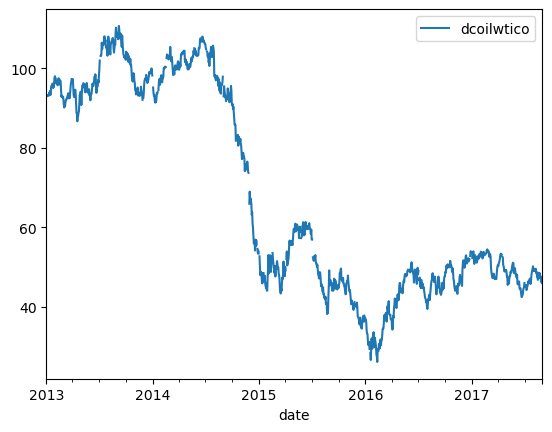

In [12]:

df_oil.plot()

**Remark** : We can observe here that there is a downward trend in the price of oil, it fell 2015 down to 2016 and then sarted gaining in 2017

In [13]:
#Since we see a trend in the data and also we realised that the first value is also missing we would then use a backwardfill to tackle our missing values 
df_oil["dcoilwtico"]= df_oil["dcoilwtico"].fillna(method= "bfill")
df_oil.isna().sum()

dcoilwtico    0
dtype: int64

__HOLIDAY__

In [14]:
holidays.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [15]:
holidays.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [16]:
#Copy to work on 
df_holi = holidays.copy()


In [17]:
##Let's use a bubble plot to visualize the most prominent 
##We are trying to group the holidays based on count. And we are creating a column known as count. 
typ_cnts = df_holi.groupby('type').size().reset_index(name="count")
typ_cnts

type  count
0  Additional     51
1      Bridge      5
2       Event     56
3     Holiday    221
4    Transfer     12
5    Work Day      5

In [18]:
fig = ex.scatter(typ_cnts, x='type', y='count', size='count', color= "type", hover_name='type',
                 log_y=False, size_max=60)
fig.show()

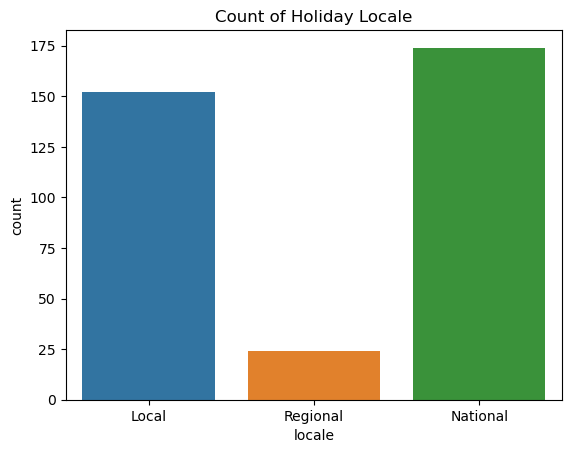

In [19]:
#Creating a count of the Holiday Locale 
plt.title("Count of Holiday Locale")
sns.countplot("locale", data= df_holi)
plt.show()

In [20]:
#checking for the total number of Holidys that were transfered
trans_count= df_holi.groupby("transferred").size().reset_index(name="count")
trans_count

transferred  count
0        False    338
1         True     12

([<matplotlib.patches.Wedge at 0x1e641886430>,
 [Text(-1.0936251618386073, 0.11825398679740307, 'False'),
  Text(1.0936251576867049, -0.11825402519461974, 'True')],
 [Text(-0.5965228155483311, 0.0645021746167653, '97%'),
  Text(0.5965228132836572, -0.06450219556070166, '3%')])

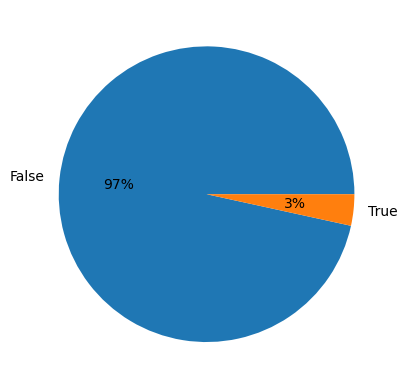

In [21]:
#palette_color = sns.color_palette('bright')
plt.pie(data= trans_count, x= "count", labels= "transferred", autopct='%.0f%%' )

**Remark** : 
1. there are more national holidays as compared to the other ones 
2. We had 2 Holidays days being trasnfered, constituting just 3%

__STORES__

In [22]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [23]:
df_store = stores.copy()

In [24]:
df_store.describe().T

count       mean        std  min    25%   50%    75%   max
store_nbr   54.0  27.500000  15.732133  1.0  14.25  27.5  40.75  54.0
cluster     54.0   8.481481   4.693395  1.0   4.00   8.5  13.00  17.0

In [25]:
clus_cnt= df_store.groupby("cluster").size().reset_index(name="count")
clus_cnt.T

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
cluster   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
count     3   2   7   3   1   6   2   3   2   6   3   1   4   4   5   1   1

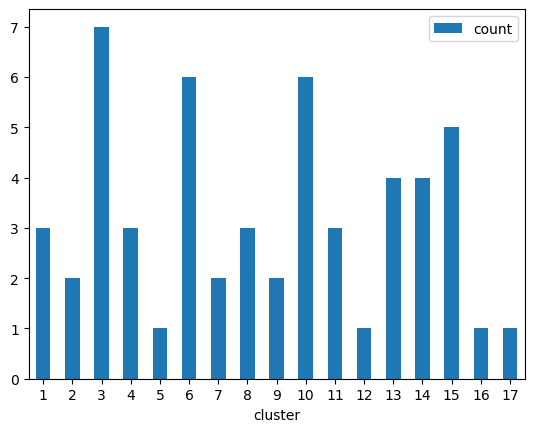

In [26]:
ax = clus_cnt.plot.bar(x='cluster', y='count', rot=0)

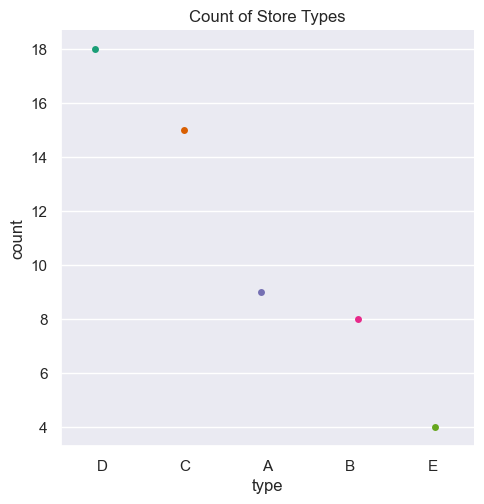

In [27]:
type_count= stores.type.value_counts().reset_index()

type_count.columns= ["type", "count"]

sns.set(rc={"figure.figsize": (10,5)})
sns.catplot("type", data=type_count, y= "count", palette= "Dark2")

plt.title("Count of Store Types")


##store type D has the highest count

plt.show()

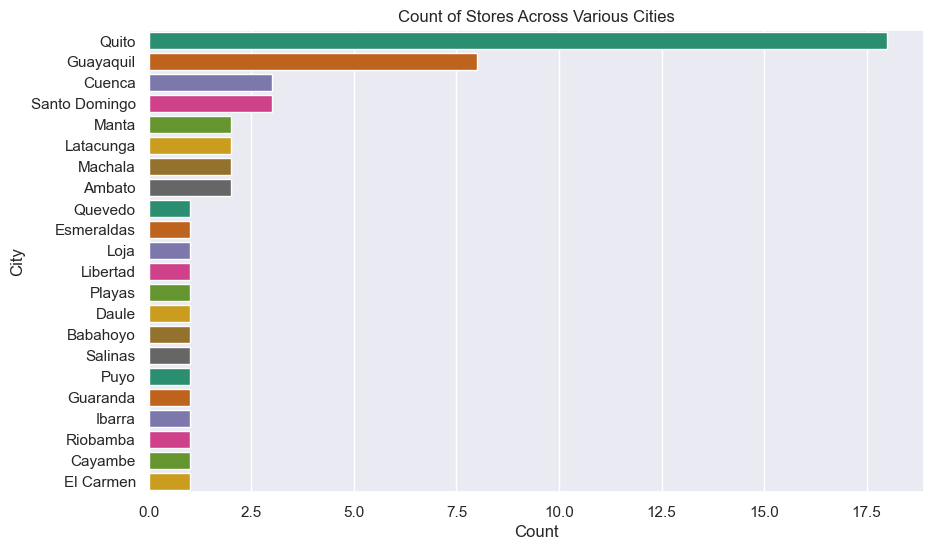

In [28]:
city_count = stores.city.value_counts().reset_index()
city_count.columns = ["city", "count"]


plt.figure(figsize=(10, 6))
sns.barplot(data=city_count, y="city", x="count", palette="Dark2")
plt.title("Count of Stores Across Various Cities")
plt.xlabel("Count")
plt.ylabel("City")
plt.show()


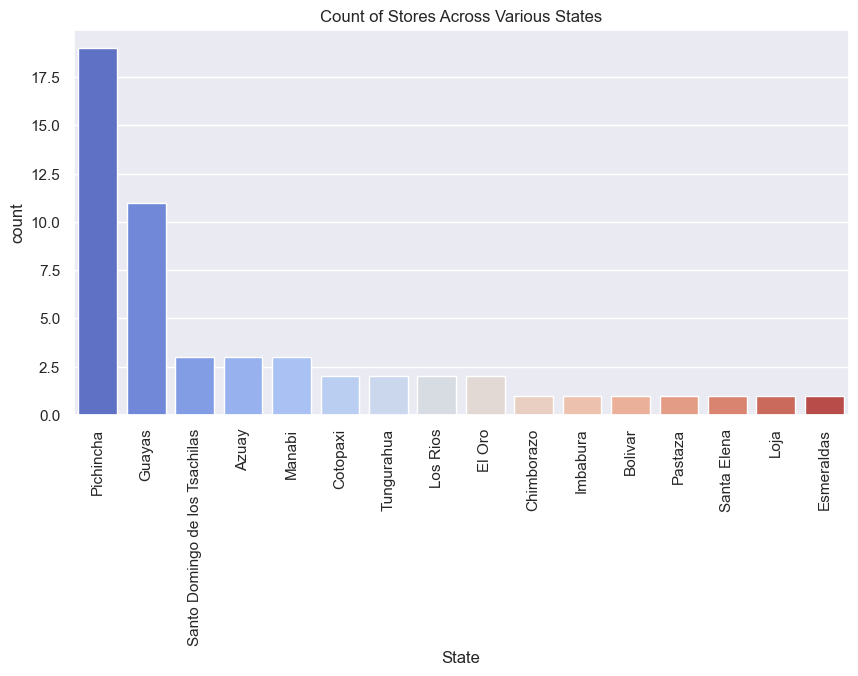

<Figure size 2000x1500 with 0 Axes>

In [29]:
## Checking to see the occurence of each store across Ecaudor
state_count= stores.state.value_counts().reset_index()

state_count.columns= ["State", "count"]

sns.barplot("State", data=state_count, y= "count", palette= "coolwarm")

plt.title("Count of Stores Across Various States")
plt.xticks(rotation=90)
plt.figure(figsize= (20,15))

plt.show()

In [30]:
#Checking unique Stores 
print("There are:", len(stores.store_nbr.unique()), "Unique Stores")

There are: 54 Unique Stores


__Remarks__ 
- The 54 unique stores across the states
- There are 22 cities and 16 states
- Quito and Pichincha has the highest count of stores.
- There are 5 unique types of Stores.
- There also 17 unique clusters

__TRANSACTION__

In [31]:
transactions.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [32]:
df_trans = transactions.copy().set_index("date")
df_trans.head()

store_nbr  transactions
date                               
2013-01-01         25           770
2013-01-02          1          2111
2013-01-02          2          2358
2013-01-02          3          3487
2013-01-02          4          1922

In [33]:
fig = ex.line(x= df_trans.index, y = "transactions", data_frame = df_trans)

fig.update_xaxes(rangeslider_visible = True)

fig.show()

__Remarks__ we can see some spikes whhich signifies seasonality at the begining of every year.

### Check for Outliers

<AxesSubplot:>

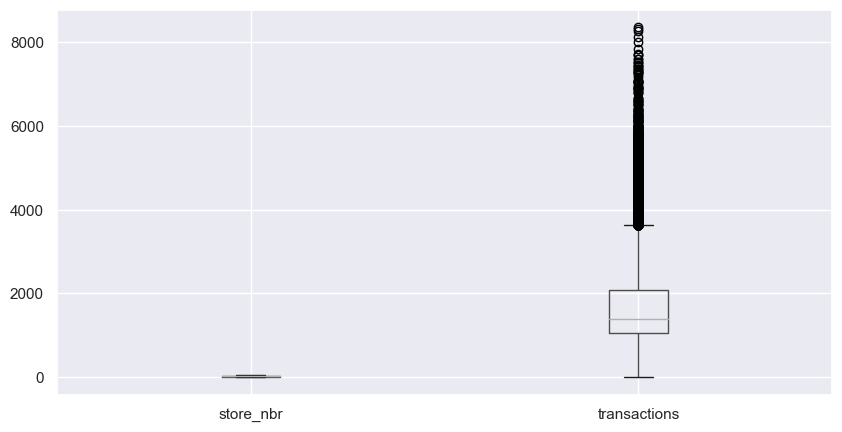

In [34]:
transactions.boxplot()

 During the analysis, the median will be used when plotting the resampled values since there are outliers

## Transaction Data Resampling

In [35]:
monthly_trans= df_trans.drop(labels= "store_nbr",axis= 1).resample("M").median()
monthly_trans.head()

transactions
date                    
2013-01-31        1386.0
2013-02-28        1403.5
2013-03-31        1424.0
2013-04-30        1423.5
2013-05-31        1424.0

Text(0.5, 1.0, ' Monthly Average Transactions')

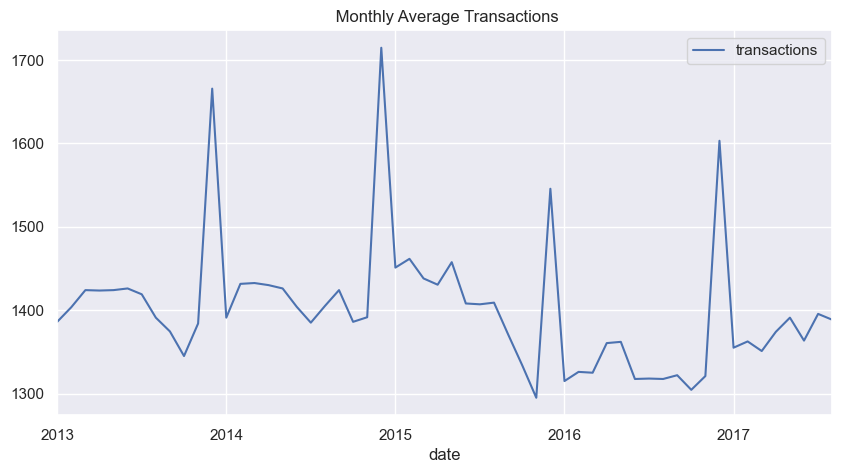

In [36]:
monthly_trans.plot()
plt.title(" Monthly Average Transactions")

### Remarks
From the plot, there is a sharp rise in transactions every December indicating some form of seasonality.
 Also, getting to the middle of each year, there is a rise in transactions made

__TEST__

In [37]:
test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [38]:
test.shape

(28512, 5)

this is our test data and we would not to dole 

### TRAIN

In [39]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [40]:
train.shape

(3000888, 6)

In [41]:
df_train = train.copy().set_index("date")

In [42]:
df_train

id  store_nbr                      family     sales  \
date                                                                   
2013-01-01        0          1                  AUTOMOTIVE     0.000   
2013-01-01        1          1                   BABY CARE     0.000   
2013-01-01        2          1                      BEAUTY     0.000   
2013-01-01        3          1                   BEVERAGES     0.000   
2013-01-01        4          1                       BOOKS     0.000   
...             ...        ...                         ...       ...   
2017-08-15  3000883          9                     POULTRY   438.133   
2017-08-15  3000884          9              PREPARED FOODS   154.553   
2017-08-15  3000885          9                     PRODUCE  2419.729   
2017-08-15  3000886          9  SCHOOL AND OFFICE SUPPLIES   121.000   
2017-08-15  3000887          9                     SEAFOOD    16.000   

            onpromotion  
date                     
2013-01-01            0  
2013-01-01            0  
2013-01-01            0  
2013-01-01            0  
2013-01-01            0  
...                 ...  
2017-08-15            0  
2017-08-15            1  
2017-08-15          148  
2017-08-15            8  
2017-08-15            0  

[3000888 rows x 5 columns]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'store_nbr'}>],
       [<AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'onpromotion'}>]], dtype=object)

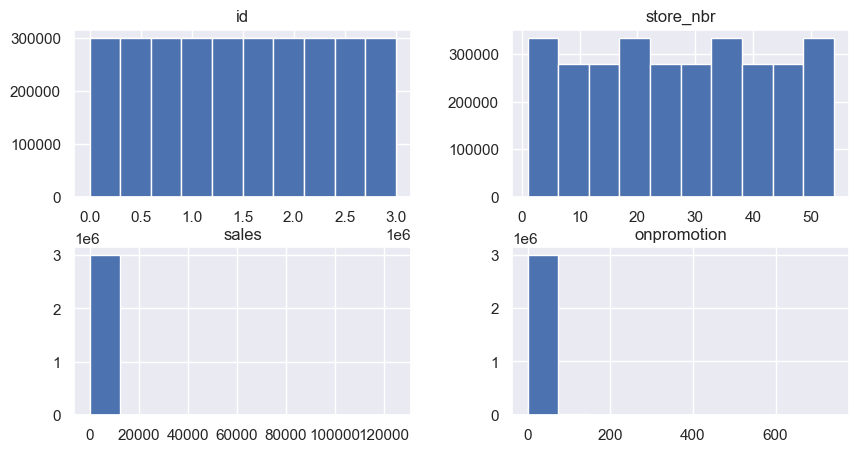

In [43]:
df_train.hist()


<AxesSubplot:>

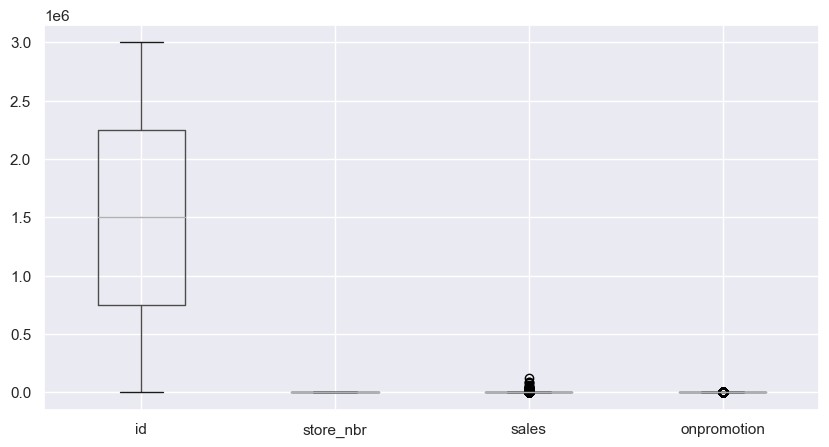

In [44]:
#check for outliers
df_train.boxplot()

There are outliers on the sale column

__SALES ATTRIBUTE__

Text(0.5, 1.0, 'Sales with respect to Time')

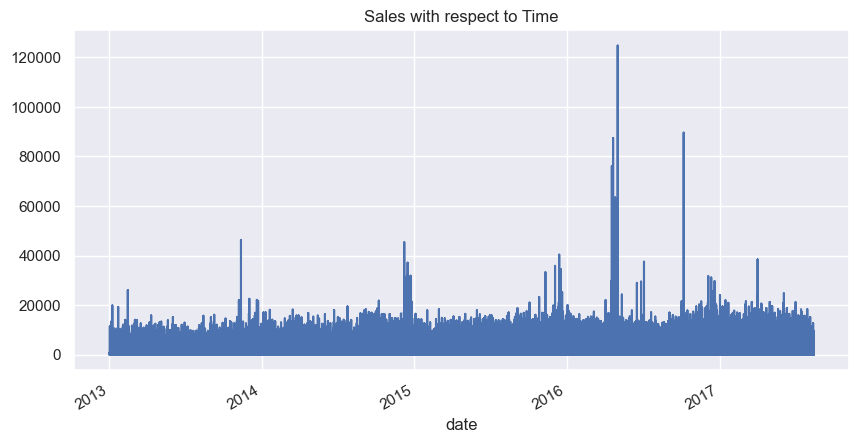

In [45]:
df_train.sales.plot()
plt.title("Sales with respect to Time")

_Daily Sales Resampling_

<AxesSubplot:title={'center':'Daily Sales for Corporation  Favorita'}, xlabel='date'>

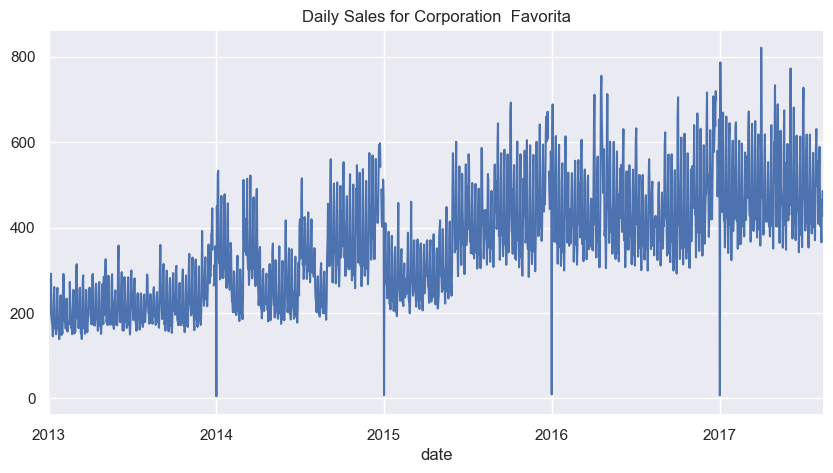

In [46]:

Daily_Sales= df_train["sales"].resample("D").mean()

plt.title("Daily Sales for Corporation  Favorita")

Daily_Sales.plot()

__Remark__:
Generally, there is an upward trend in the daily sales

 __Weekly sales Resampling__

<AxesSubplot:title={'center':'Weekly Sales for Corporation Favorita'}, xlabel='date'>

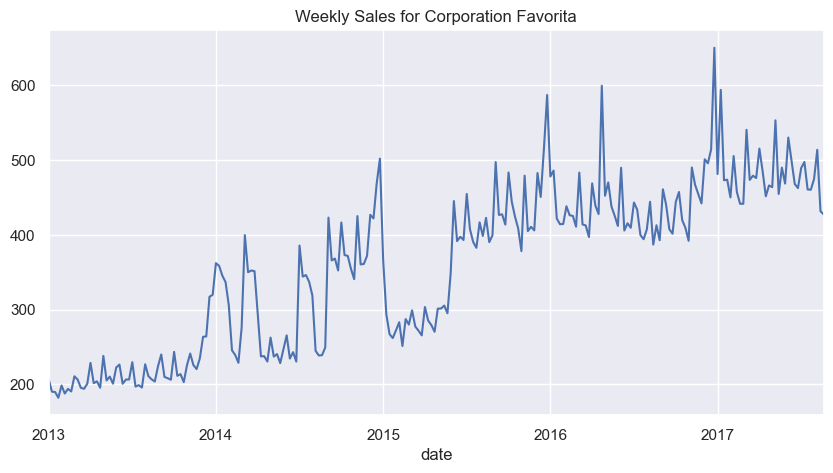

In [47]:
weekly_sales= df_train["sales"].resample("W").mean()

plt.title("Weekly Sales for Corporation Favorita")

weekly_sales.plot()

__.__ There is a trend in  the weekly sales

<AxesSubplot:title={'center':'Monthly Sales for Corporation Favorita'}, xlabel='date'>

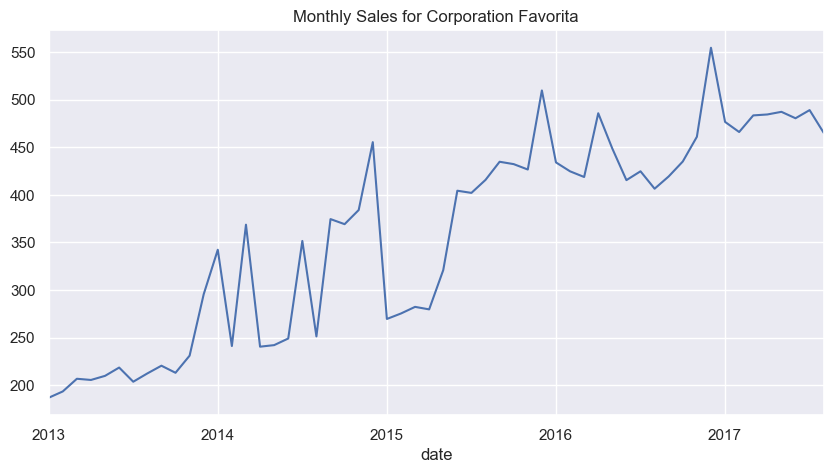

In [48]:
Monthly_sales= df_train["sales"].resample("M").mean()

plt.title("Monthly Sales for Corporation Favorita")

Monthly_sales.plot()

__.__ There is a trend in the monthly sales

Since this is our training data we will just proceed to merge them 


In [49]:
sample_submission.head()

id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0

In [50]:
merged_1 = pd.merge(train, transactions, how='outer', on=['date', 'store_nbr'])

merged_2 = pd.merge(merged_1, holidays, how='outer', on='date')

merged_3 = pd.merge(merged_2, oil, how='outer', on='date')

merged = pd.merge(merged_3, stores, how='outer', on='store_nbr')

In [51]:
merged.head()

id       date  store_nbr      family  sales  onpromotion  transactions  \
0  0.0 2013-01-01        1.0  AUTOMOTIVE    0.0          0.0           NaN   
1  1.0 2013-01-01        1.0   BABY CARE    0.0          0.0           NaN   
2  2.0 2013-01-01        1.0      BEAUTY    0.0          0.0           NaN   
3  3.0 2013-01-01        1.0   BEVERAGES    0.0          0.0           NaN   
4  4.0 2013-01-01        1.0       BOOKS    0.0          0.0           NaN   

    type_x    locale locale_name         description transferred  dcoilwtico  \
0  Holiday  National     Ecuador  Primer dia del ano       False         NaN   
1  Holiday  National     Ecuador  Primer dia del ano       False         NaN   
2  Holiday  National     Ecuador  Primer dia del ano       False         NaN   
3  Holiday  National     Ecuador  Primer dia del ano       False         NaN   
4  Holiday  National     Ecuador  Primer dia del ano       False         NaN   

    city      state type_y  cluster  
0  Quito  Pichincha      D     13.0  
1  Quito  Pichincha      D     13.0  
2  Quito  Pichincha      D     13.0  
3  Quito  Pichincha      D     13.0  
4  Quito  Pichincha      D     13.0

__Remark__
: it was oberved that the has been some new column names created, type_x and type_y

In [52]:
#Rename column name type x and type y 
merged = merged.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})

merged.head()

id       date  store_nbr      family  sales  onpromotion  transactions  \
0  0.0 2013-01-01        1.0  AUTOMOTIVE    0.0          0.0           NaN   
1  1.0 2013-01-01        1.0   BABY CARE    0.0          0.0           NaN   
2  2.0 2013-01-01        1.0      BEAUTY    0.0          0.0           NaN   
3  3.0 2013-01-01        1.0   BEVERAGES    0.0          0.0           NaN   
4  4.0 2013-01-01        1.0       BOOKS    0.0          0.0           NaN   

  holiday_type    locale locale_name         description transferred  \
0      Holiday  National     Ecuador  Primer dia del ano       False   
1      Holiday  National     Ecuador  Primer dia del ano       False   
2      Holiday  National     Ecuador  Primer dia del ano       False   
3      Holiday  National     Ecuador  Primer dia del ano       False   
4      Holiday  National     Ecuador  Primer dia del ano       False   

   dcoilwtico   city      state store_type  cluster  
0         NaN  Quito  Pichincha          D     13.0  
1         NaN  Quito  Pichincha          D     13.0  
2         NaN  Quito  Pichincha          D     13.0  
3         NaN  Quito  Pichincha          D     13.0  
4         NaN  Quito  Pichincha          D     13.0

In [53]:
merged["transferred"].unique()

array([False, nan, True], dtype=object)

In [54]:
merged["transferred"]= merged["transferred"].replace(np.nan, "False")

In [55]:
merged['transferred'].unique()

array([False, 'False', True], dtype=object)

It can be observed that, the transferred column has three unique values rather than two; a Boolean False and a string false. The string False will be replaced with the Boolean False

In [56]:
merged["transferred"]= merged["transferred"].replace("False", False)

In [57]:
merged['transferred'].unique()

array([False,  True])

Now we will perform a overview on our dataset

__MULTIVARIATE ANALYSIS__

In [58]:
corr = df_train.corr()
corr

id  store_nbr     sales  onpromotion
id           1.000000   0.000301  0.085784     0.206260
store_nbr    0.000301   1.000000  0.041196     0.007286
sales        0.085784   0.041196  1.000000     0.427923
onpromotion  0.206260   0.007286  0.427923     1.000000

<AxesSubplot:>

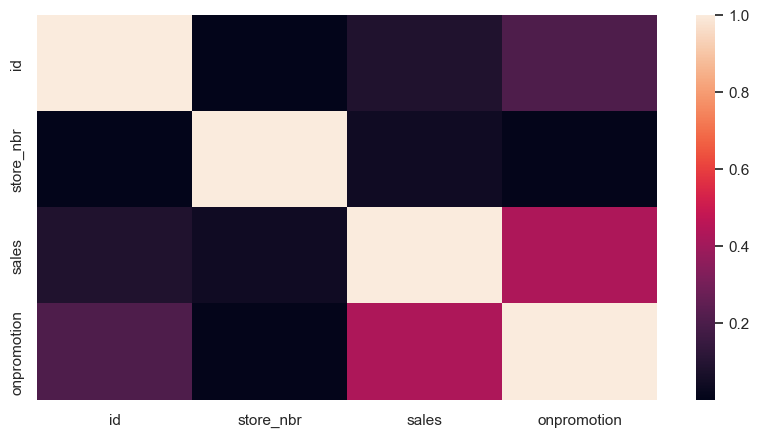

In [59]:
#visualize correlation

sns.heatmap(corr)

### ANSWERING ANALYTICAL QUESTIONS

### Q1.Which store had the highest sales?

Text(0.5, 1.0, 'Top 5 Store with the Highest Sale')

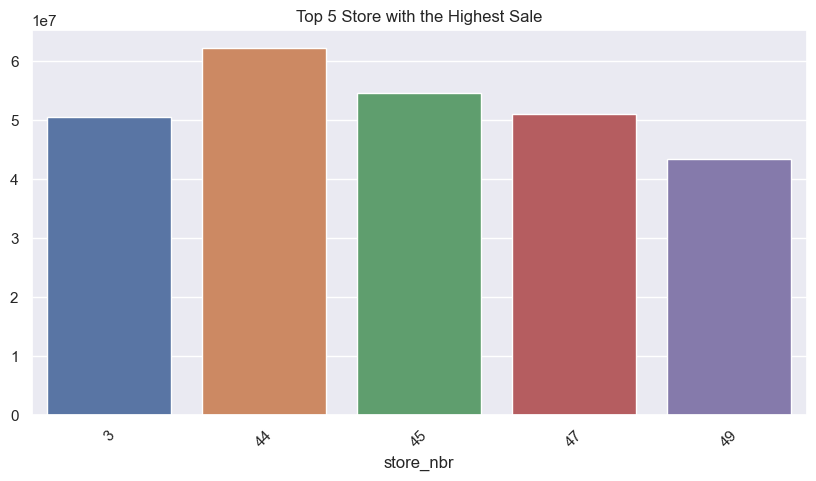

In [60]:
sto_sale= df_train.groupby("store_nbr")["sales"].agg("sum").sort_values(ascending= False).head()

sns.barplot(x=sto_sale.index, y=sto_sale.values)


plt.xticks(rotation= 45)
plt.title('Top 5 Store with the Highest Sale')

In [61]:
family_bought= df_train[df_train["sales"]!=0 ]

##Lets group and plot

family_sale = family_bought.groupby('family').size().reset_index(name='count').sort_values(by= "count")


fig_2= ex.scatter(family_sale, x='family', y='count', size='count', color= "family", hover_name='family',
                log_y=False, size_max=60)

fig_2.show()

### Q3.Which month had the highest sale?

In [62]:
train_df = train

In [63]:
##to find this, we will group our unit sales by month across all the years
train_df["month"]= train_df["date"].dt.month
train_df["day"]= train_df["date"].dt.day
train_df["year"]= train_df["date"].dt.year

In [64]:
train_df

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  month  day  year  
0                  0      1    1  2013  
1                  0      1    1  2013  
2                  0      1    1  2013  
3                  0      1    1  2013  
4                  0      1    1  2013  
...              ...    ...  ...   ...  
3000883            0      8   15  2017  
3000884            1      8   15  2017  
3000885          148      8   15  2017  
3000886            8      8   15  2017  
3000887            0      8   15  2017  

[3000888 rows x 9 columns]

<AxesSubplot:xlabel='month', ylabel='sales'>

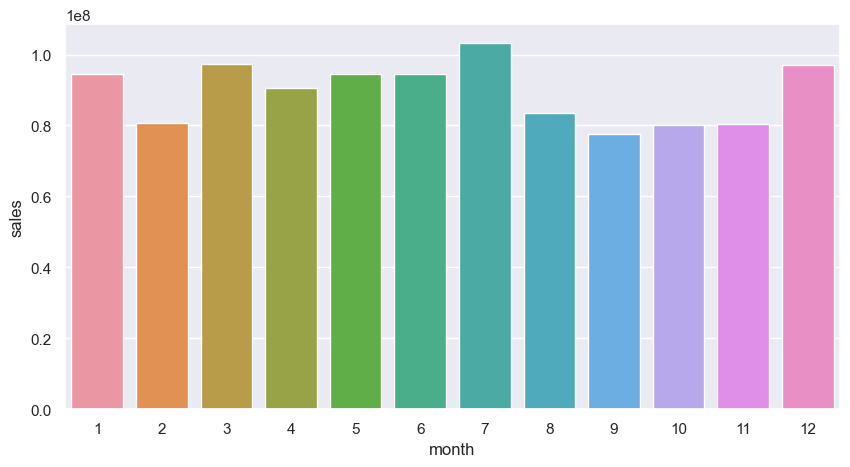

In [65]:
# the sales by month
monthly_sales = train_df.groupby("month").agg({"sales":"sum"}).sort_values(by="sales")

#visualising
sns.barplot(data = monthly_sales, x= monthly_sales.index, y= "sales" )

### Q4. Which Store had the highest transaction?

Text(0.5, 1.0, 'Top 5 Store with the Highest Transactions')

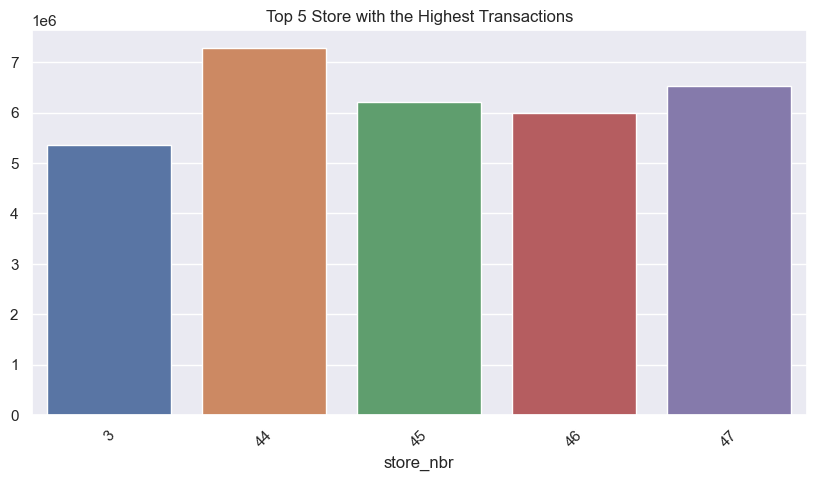

In [66]:
sto_tran = transactions.groupby("store_nbr")["transactions"].agg("sum").sort_values(ascending= False).head()

sns.barplot(x=sto_tran.index, y=sto_tran.values)

plt.xticks(rotation= 45)
plt.title('Top 5 Store with the Highest Transactions')

### Q5 Which year had the highest Transaction made?

<AxesSubplot:ylabel='sales'>

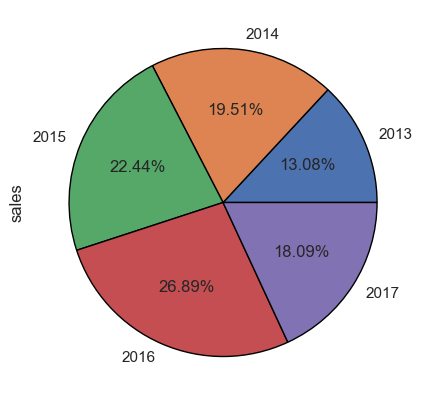

In [67]:
yearly_sales = train_df.groupby("year")["sales"].sum().plot(kind="pie", y="sales", autopct = '%1.2f%%', wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
yearly_sales

The highest transactions were made in the year 2016

## MODELLING


Firstly, a univariate modelling will be employed to predict current sales using past sales.This will be done using ARIMA and SARIMA models.    
The ARIMA model is a classical time series forecasting model. ARIMA can capture autoregressive and moving average components in the data.

The SARIMA model extends ARIMA to include seasonal components. SARIMA best suited  for capturing seasonal patterns in the data along with autoregressive and moving average components.

Secondly, the effect of other features on the target will be explored using SARIMAX and other machine learning models like XGBoost Regressor,CatBoost Regressor,Random Forest and Decision Tree. This is a form of multivariate modelling. 

XGBoost Regressor is a gradient boosting algorithm popular for its speed and performance. It can handle both numerical and categorical features and is effective in capturing complex relationships in the data.

CatBoost Regressor is another gradient boosting algorithm that excels in handling categorical features. It automatically handles categorical variables and provides accurate predictions with minimal data preprocessing.


__UNIVARIATE MODELLING__

Sales will be forcasted using time only and the values of past sales in this form of modelling.

In [68]:
train_df

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  month  day  year  
0                  0      1    1  2013  
1                  0      1    1  2013  
2                  0      1    1  2013  
3                  0      1    1  2013  
4                  0      1    1  2013  
...              ...    ...  ...   ...  
3000883            0      8   15  2017  
3000884            1      8   15  2017  
3000885          148      8   15  2017  
3000886            8      8   15  2017  
3000887            0      8   15  2017  

[3000888 rows x 9 columns]

In [69]:
# To get an idea of the the daily total unit sales from the various stores,the train data will be grouped by date. To make the time the index, a new data frame will be created 


Sale_uni= train_df.drop(["id", "store_nbr", "family", "onpromotion", "month","day","year"], axis=1)

Sale_uni= Sale_uni.set_index("date")


In [70]:
Sale_uni= Sale_uni.groupby(Sale_uni.index).agg({"sales": sum})


<AxesSubplot:xlabel='date'>

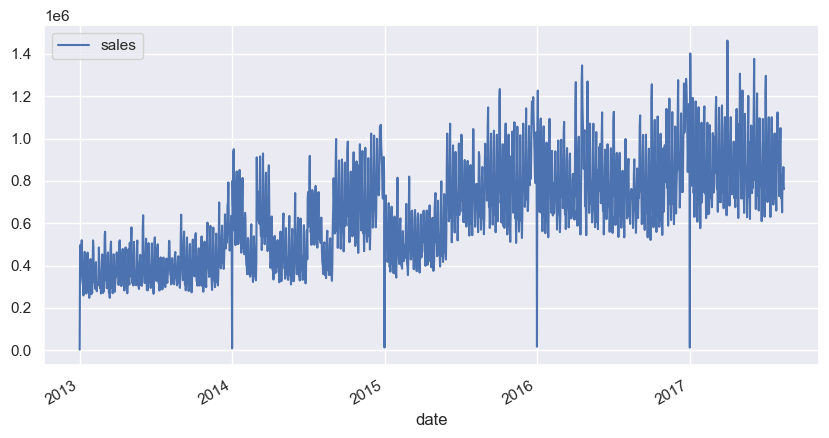

In [71]:
Sale_uni.plot()

It can be seen that, they were decline in sales at the begining of each year

__MODELLING WITH TIME SERIES MODELS__

__Testing for Stationarity__

Stationarity can be determined using the following:

**Autocorrelation Function(ACF) and Partial Autocorrelation Function(PACF)  plots:** If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.



**Augmented Dickey-Fuller Test(ADF):** This is one of the statistical tests for checking stationarity. The test result consists of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, it can be concluded that the series is stationary. 


__Autocorrelation Function(ACF) and Partial Autocorrelation Function(PACF) plots__

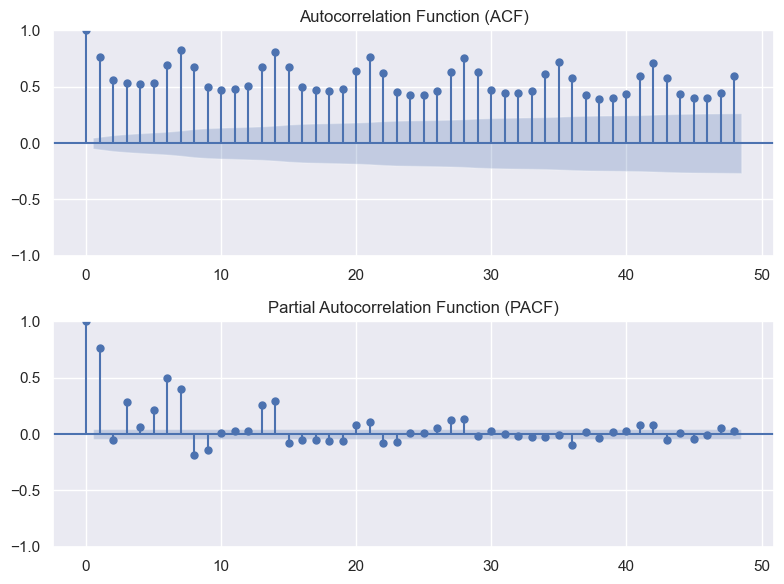

In [72]:
##setting up subplot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

#ACF plot
ACF(Sale_uni, lags=48, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
PACF(Sale_uni, lags=48, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

It is observed from the ACF chart that,all the lags are above the significance level.
From the PACF chart, majority of the lags are also above the significant level

__Augmented Dickey-Fuller Test(ADF)__

In [73]:
Outcome= adf((Sale_uni))

Outcome

(-2.616195748604857,
 0.08969592175787466,
 22,
 1661,
 {'1%': -3.4342930672797065,
  '5%': -2.8632816397229064,
  '10%': -2.567697207194407},
 42848.480392783786)

Using a confidence level of 5%, the p-value is less than 0.05 hence the data is non-stationary

__To see the components of the data, it is decomposed__

<Figure size 2000x2000 with 0 Axes>

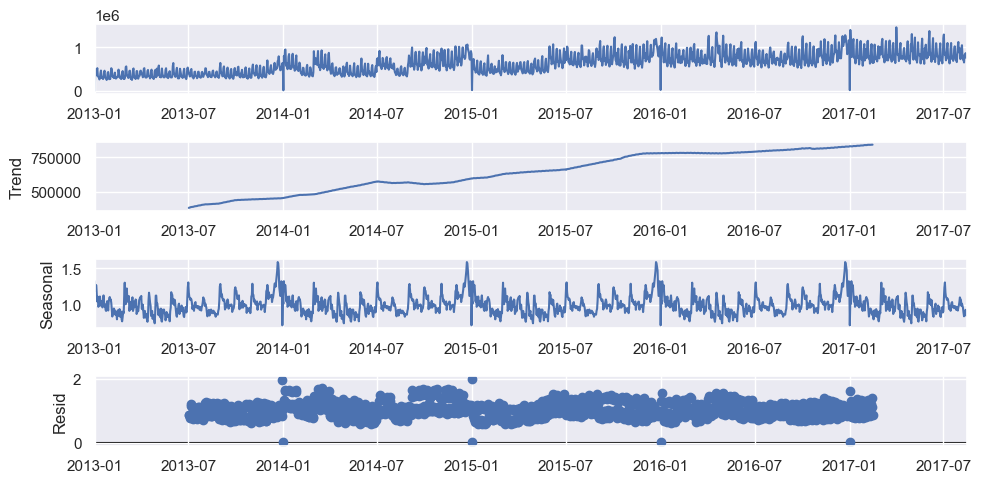

<Figure size 2000x2000 with 0 Axes>

In [74]:
decomposed_data= sma.tsa.seasonal_decompose(Sale_uni, model= "multiplicative", period=365 )

decomposed_data.plot()

plt.figure(figsize= (20,20))

#__Splitting Data__

In [75]:
train

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  month  day  year  
0                  0      1    1  2013  
1                  0      1    1  2013  
2                  0      1    1  2013  
3                  0      1    1  2013  
4                  0      1    1  2013  
...              ...    ...  ...   ...  
3000883            0      8   15  2017  
3000884            1      8   15  2017  
3000885          148      8   15  2017  
3000886            8      8   15  2017  
3000887            0      8   15  2017  

[3000888 rows x 9 columns]

__AUTOARIMA MODEL__

The autoarima will be employed to find out p and q values.

### MULTIVARIATE MODELLING

We will explore how sales is affected by other exogenous variables. The time series dataset will be merged and used. Feature selection and engineering will be done. The models that will be employed are the XGBoost, Random Forest, Decision Tree,KNN and SARIMAX


In [76]:
merged

id       date  store_nbr      family  sales  onpromotion  \
0        0.0 2013-01-01        1.0  AUTOMOTIVE    0.0          0.0   
1        1.0 2013-01-01        1.0   BABY CARE    0.0          0.0   
2        2.0 2013-01-01        1.0      BEAUTY    0.0          0.0   
3        3.0 2013-01-01        1.0   BEVERAGES    0.0          0.0   
4        4.0 2013-01-01        1.0       BOOKS    0.0          0.0   
...      ...        ...        ...         ...    ...          ...   
3054422  NaN 2017-08-25        NaN         NaN    NaN          NaN   
3054423  NaN 2017-08-28        NaN         NaN    NaN          NaN   
3054424  NaN 2017-08-29        NaN         NaN    NaN          NaN   
3054425  NaN 2017-08-30        NaN         NaN    NaN          NaN   
3054426  NaN 2017-08-31        NaN         NaN    NaN          NaN   

         transactions holiday_type    locale locale_name         description  \
0                 NaN      Holiday  National     Ecuador  Primer dia del ano   
1                 NaN      Holiday  National     Ecuador  Primer dia del ano   
2                 NaN      Holiday  National     Ecuador  Primer dia del ano   
3                 NaN      Holiday  National     Ecuador  Primer dia del ano   
4                 NaN      Holiday  National     Ecuador  Primer dia del ano   
...               ...          ...       ...         ...                 ...   
3054422           NaN          NaN       NaN         NaN                 NaN   
3054423           NaN          NaN       NaN         NaN                 NaN   
3054424           NaN          NaN       NaN         NaN                 NaN   
3054425           NaN          NaN       NaN         NaN                 NaN   
3054426           NaN          NaN       NaN         NaN                 NaN   

         transferred  dcoilwtico   city      state store_type  cluster  
0              False         NaN  Quito  Pichincha          D     13.0  
1              False         NaN  Quito  Pichincha          D     13.0  
2              False         NaN  Quito  Pichincha          D     13.0  
3              False         NaN  Quito  Pichincha          D     13.0  
4              False         NaN  Quito  Pichincha          D     13.0  
...              ...         ...    ...        ...        ...      ...  
3054422        False   47.650002    NaN        NaN        NaN      NaN  
3054423        False   46.400002    NaN        NaN        NaN      NaN  
3054424        False   46.459999    NaN        NaN        NaN      NaN  
3054425        False   45.959999    NaN        NaN        NaN      NaN  
3054426        False   47.259998    NaN        NaN        NaN      NaN  

[3054427 rows x 17 columns]

In [77]:
#merged_3

In [78]:
## rename the type column to holiday type

merged= merged.rename(columns= {"type_x": "holiday"})

In [79]:
merged

id       date  store_nbr      family  sales  onpromotion  \
0        0.0 2013-01-01        1.0  AUTOMOTIVE    0.0          0.0   
1        1.0 2013-01-01        1.0   BABY CARE    0.0          0.0   
2        2.0 2013-01-01        1.0      BEAUTY    0.0          0.0   
3        3.0 2013-01-01        1.0   BEVERAGES    0.0          0.0   
4        4.0 2013-01-01        1.0       BOOKS    0.0          0.0   
...      ...        ...        ...         ...    ...          ...   
3054422  NaN 2017-08-25        NaN         NaN    NaN          NaN   
3054423  NaN 2017-08-28        NaN         NaN    NaN          NaN   
3054424  NaN 2017-08-29        NaN         NaN    NaN          NaN   
3054425  NaN 2017-08-30        NaN         NaN    NaN          NaN   
3054426  NaN 2017-08-31        NaN         NaN    NaN          NaN   

         transactions holiday_type    locale locale_name         description  \
0                 NaN      Holiday  National     Ecuador  Primer dia del ano   
1                 NaN      Holiday  National     Ecuador  Primer dia del ano   
2                 NaN      Holiday  National     Ecuador  Primer dia del ano   
3                 NaN      Holiday  National     Ecuador  Primer dia del ano   
4                 NaN      Holiday  National     Ecuador  Primer dia del ano   
...               ...          ...       ...         ...                 ...   
3054422           NaN          NaN       NaN         NaN                 NaN   
3054423           NaN          NaN       NaN         NaN                 NaN   
3054424           NaN          NaN       NaN         NaN                 NaN   
3054425           NaN          NaN       NaN         NaN                 NaN   
3054426           NaN          NaN       NaN         NaN                 NaN   

         transferred  dcoilwtico   city      state store_type  cluster  
0              False         NaN  Quito  Pichincha          D     13.0  
1              False         NaN  Quito  Pichincha          D     13.0  
2              False         NaN  Quito  Pichincha          D     13.0  
3              False         NaN  Quito  Pichincha          D     13.0  
4              False         NaN  Quito  Pichincha          D     13.0  
...              ...         ...    ...        ...        ...      ...  
3054422        False   47.650002    NaN        NaN        NaN      NaN  
3054423        False   46.400002    NaN        NaN        NaN      NaN  
3054424        False   46.459999    NaN        NaN        NaN      NaN  
3054425        False   45.959999    NaN        NaN        NaN      NaN  
3054426        False   47.259998    NaN        NaN        NaN      NaN  

[3054427 rows x 17 columns]

__Dealing with Missing Values__

In [80]:
merged.isna().sum()

id                   79
date                  0
store_nbr            79
family               79
sales                79
onpromotion          79
transactions     249196
holiday_type    2551835
locale          2551835
locale_name     2551835
description     2551835
transferred           0
dcoilwtico       955219
city                 79
state                79
store_type           79
cluster              79
dtype: int64

In [81]:
merged= merged.dropna(subset=["sales", "onpromotion"])

In [82]:
## Replace na values with 0 since no transactions were recorded on the particular date 

merged["transactions"]= merged["transactions"].replace(np.nan, 0)

In [83]:
merged.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions          0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred           0
dcoilwtico       955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

For transferred, the missing values will be replaced with false;the missing values for holidays will be replaced with not holidays and for locale, missing values will be replaced with not holiday. A backfill will be done for dcoilwtico since the values closely match





In [84]:
merged

id       date  store_nbr                      family  \
0              0.0 2013-01-01        1.0                  AUTOMOTIVE   
1              1.0 2013-01-01        1.0                   BABY CARE   
2              2.0 2013-01-01        1.0                      BEAUTY   
3              3.0 2013-01-01        1.0                   BEVERAGES   
4              4.0 2013-01-01        1.0                       BOOKS   
...            ...        ...        ...                         ...   
3054343  3000883.0 2017-08-15        9.0                     POULTRY   
3054344  3000884.0 2017-08-15        9.0              PREPARED FOODS   
3054345  3000885.0 2017-08-15        9.0                     PRODUCE   
3054346  3000886.0 2017-08-15        9.0  SCHOOL AND OFFICE SUPPLIES   
3054347  3000887.0 2017-08-15        9.0                     SEAFOOD   

            sales  onpromotion  transactions holiday_type    locale  \
0           0.000          0.0           0.0      Holiday  National   
1           0.000          0.0           0.0      Holiday  National   
2           0.000          0.0           0.0      Holiday  National   
3           0.000          0.0           0.0      Holiday  National   
4           0.000          0.0           0.0      Holiday  National   
...           ...          ...           ...          ...       ...   
3054343   438.133          0.0        2155.0      Holiday     Local   
3054344   154.553          1.0        2155.0      Holiday     Local   
3054345  2419.729        148.0        2155.0      Holiday     Local   
3054346   121.000          8.0        2155.0      Holiday     Local   
3054347    16.000          0.0        2155.0      Holiday     Local   

        locale_name            description  transferred  dcoilwtico   city  \
0           Ecuador     Primer dia del ano        False         NaN  Quito   
1           Ecuador     Primer dia del ano        False         NaN  Quito   
2           Ecuador     Primer dia del ano        False         NaN  Quito   
3           Ecuador     Primer dia del ano        False         NaN  Quito   
4           Ecuador     Primer dia del ano        False         NaN  Quito   
...             ...                    ...          ...         ...    ...   
3054343    Riobamba  Fundacion de Riobamba        False       47.57  Quito   
3054344    Riobamba  Fundacion de Riobamba        False       47.57  Quito   
3054345    Riobamba  Fundacion de Riobamba        False       47.57  Quito   
3054346    Riobamba  Fundacion de Riobamba        False       47.57  Quito   
3054347    Riobamba  Fundacion de Riobamba        False       47.57  Quito   

             state store_type  cluster  
0        Pichincha          D     13.0  
1        Pichincha          D     13.0  
2        Pichincha          D     13.0  
3        Pichincha          D     13.0  
4        Pichincha          D     13.0  
...            ...        ...      ...  
3054343  Pichincha          B      6.0  
3054344  Pichincha          B      6.0  
3054345  Pichincha          B      6.0  
3054346  Pichincha          B      6.0  
3054347  Pichincha          B      6.0  

[3054348 rows x 17 columns]

In [85]:
merged["holiday_type"]= merged["holiday_type"].replace(np.nan, "Not Holiday")

merged["locale"]= merged["locale"].replace(np.nan, "Not Holiday")

#merged["transferred"]= merged["transferred"].replace(np.nan, "False")

merged["dcoilwtico"]=  merged["dcoilwtico"].fillna(method= "bfill")


In [86]:
merged.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions          0
holiday_type          0
locale                0
locale_name     2551824
description     2551824
transferred           0
dcoilwtico            0
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

In [87]:
##We will be dropping the locale_name and description of holiday

merged= merged.drop(["locale_name", "description"], axis= 1)

In [88]:
merged

id       date  store_nbr                      family  \
0              0.0 2013-01-01        1.0                  AUTOMOTIVE   
1              1.0 2013-01-01        1.0                   BABY CARE   
2              2.0 2013-01-01        1.0                      BEAUTY   
3              3.0 2013-01-01        1.0                   BEVERAGES   
4              4.0 2013-01-01        1.0                       BOOKS   
...            ...        ...        ...                         ...   
3054343  3000883.0 2017-08-15        9.0                     POULTRY   
3054344  3000884.0 2017-08-15        9.0              PREPARED FOODS   
3054345  3000885.0 2017-08-15        9.0                     PRODUCE   
3054346  3000886.0 2017-08-15        9.0  SCHOOL AND OFFICE SUPPLIES   
3054347  3000887.0 2017-08-15        9.0                     SEAFOOD   

            sales  onpromotion  transactions holiday_type    locale  \
0           0.000          0.0           0.0      Holiday  National   
1           0.000          0.0           0.0      Holiday  National   
2           0.000          0.0           0.0      Holiday  National   
3           0.000          0.0           0.0      Holiday  National   
4           0.000          0.0           0.0      Holiday  National   
...           ...          ...           ...          ...       ...   
3054343   438.133          0.0        2155.0      Holiday     Local   
3054344   154.553          1.0        2155.0      Holiday     Local   
3054345  2419.729        148.0        2155.0      Holiday     Local   
3054346   121.000          8.0        2155.0      Holiday     Local   
3054347    16.000          0.0        2155.0      Holiday     Local   

         transferred  dcoilwtico   city      state store_type  cluster  
0              False   93.139999  Quito  Pichincha          D     13.0  
1              False   93.139999  Quito  Pichincha          D     13.0  
2              False   93.139999  Quito  Pichincha          D     13.0  
3              False   93.139999  Quito  Pichincha          D     13.0  
4              False   93.139999  Quito  Pichincha          D     13.0  
...              ...         ...    ...        ...        ...      ...  
3054343        False   47.570000  Quito  Pichincha          B      6.0  
3054344        False   47.570000  Quito  Pichincha          B      6.0  
3054345        False   47.570000  Quito  Pichincha          B      6.0  
3054346        False   47.570000  Quito  Pichincha          B      6.0  
3054347        False   47.570000  Quito  Pichincha          B      6.0  

[3054348 rows x 15 columns]

In [89]:
merged.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'holiday_type', 'locale', 'transferred', 'dcoilwtico',
       'city', 'state', 'store_type', 'cluster'],
      dtype='object')

### Feature Processing

The categorical columns will be encoded and new features will be created

In [90]:
merged

id       date  store_nbr                      family  \
0              0.0 2013-01-01        1.0                  AUTOMOTIVE   
1              1.0 2013-01-01        1.0                   BABY CARE   
2              2.0 2013-01-01        1.0                      BEAUTY   
3              3.0 2013-01-01        1.0                   BEVERAGES   
4              4.0 2013-01-01        1.0                       BOOKS   
...            ...        ...        ...                         ...   
3054343  3000883.0 2017-08-15        9.0                     POULTRY   
3054344  3000884.0 2017-08-15        9.0              PREPARED FOODS   
3054345  3000885.0 2017-08-15        9.0                     PRODUCE   
3054346  3000886.0 2017-08-15        9.0  SCHOOL AND OFFICE SUPPLIES   
3054347  3000887.0 2017-08-15        9.0                     SEAFOOD   

            sales  onpromotion  transactions holiday_type    locale  \
0           0.000          0.0           0.0      Holiday  National   
1           0.000          0.0           0.0      Holiday  National   
2           0.000          0.0           0.0      Holiday  National   
3           0.000          0.0           0.0      Holiday  National   
4           0.000          0.0           0.0      Holiday  National   
...           ...          ...           ...          ...       ...   
3054343   438.133          0.0        2155.0      Holiday     Local   
3054344   154.553          1.0        2155.0      Holiday     Local   
3054345  2419.729        148.0        2155.0      Holiday     Local   
3054346   121.000          8.0        2155.0      Holiday     Local   
3054347    16.000          0.0        2155.0      Holiday     Local   

         transferred  dcoilwtico   city      state store_type  cluster  
0              False   93.139999  Quito  Pichincha          D     13.0  
1              False   93.139999  Quito  Pichincha          D     13.0  
2              False   93.139999  Quito  Pichincha          D     13.0  
3              False   93.139999  Quito  Pichincha          D     13.0  
4              False   93.139999  Quito  Pichincha          D     13.0  
...              ...         ...    ...        ...        ...      ...  
3054343        False   47.570000  Quito  Pichincha          B      6.0  
3054344        False   47.570000  Quito  Pichincha          B      6.0  
3054345        False   47.570000  Quito  Pichincha          B      6.0  
3054346        False   47.570000  Quito  Pichincha          B      6.0  
3054347        False   47.570000  Quito  Pichincha          B      6.0  

[3054348 rows x 15 columns]

__Feature Encoding__

Since the Transferred column is binary, i.e True or False, the label encoder will be used. An ordinal encoder will be used for the locale column since it consist of heirachial holiday. eg National > Local. Finally,a binary encoder will be used for the holiday column since it consist of a number of different kinds of holidays

__Transferred column Encoding__

In [91]:
LE= LabelEncoder()

In [92]:
merged["transferred"]= LE.fit_transform(merged["transferred"])

In [93]:
merged

id       date  store_nbr                      family  \
0              0.0 2013-01-01        1.0                  AUTOMOTIVE   
1              1.0 2013-01-01        1.0                   BABY CARE   
2              2.0 2013-01-01        1.0                      BEAUTY   
3              3.0 2013-01-01        1.0                   BEVERAGES   
4              4.0 2013-01-01        1.0                       BOOKS   
...            ...        ...        ...                         ...   
3054343  3000883.0 2017-08-15        9.0                     POULTRY   
3054344  3000884.0 2017-08-15        9.0              PREPARED FOODS   
3054345  3000885.0 2017-08-15        9.0                     PRODUCE   
3054346  3000886.0 2017-08-15        9.0  SCHOOL AND OFFICE SUPPLIES   
3054347  3000887.0 2017-08-15        9.0                     SEAFOOD   

            sales  onpromotion  transactions holiday_type    locale  \
0           0.000          0.0           0.0      Holiday  National   
1           0.000          0.0           0.0      Holiday  National   
2           0.000          0.0           0.0      Holiday  National   
3           0.000          0.0           0.0      Holiday  National   
4           0.000          0.0           0.0      Holiday  National   
...           ...          ...           ...          ...       ...   
3054343   438.133          0.0        2155.0      Holiday     Local   
3054344   154.553          1.0        2155.0      Holiday     Local   
3054345  2419.729        148.0        2155.0      Holiday     Local   
3054346   121.000          8.0        2155.0      Holiday     Local   
3054347    16.000          0.0        2155.0      Holiday     Local   

         transferred  dcoilwtico   city      state store_type  cluster  
0                  0   93.139999  Quito  Pichincha          D     13.0  
1                  0   93.139999  Quito  Pichincha          D     13.0  
2                  0   93.139999  Quito  Pichincha          D     13.0  
3                  0   93.139999  Quito  Pichincha          D     13.0  
4                  0   93.139999  Quito  Pichincha          D     13.0  
...              ...         ...    ...        ...        ...      ...  
3054343            0   47.570000  Quito  Pichincha          B      6.0  
3054344            0   47.570000  Quito  Pichincha          B      6.0  
3054345            0   47.570000  Quito  Pichincha          B      6.0  
3054346            0   47.570000  Quito  Pichincha          B      6.0  
3054347            0   47.570000  Quito  Pichincha          B      6.0  

[3054348 rows x 15 columns]

__Holiday attribute enconding__

In [94]:
merged["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [95]:
merged.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'holiday_type', 'locale', 'transferred', 'dcoilwtico',
       'city', 'state', 'store_type', 'cluster'],
      dtype='object')

In [96]:
merged["store_type"].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [97]:
merged["holiday_type"].unique()

array(['Holiday', 'Not Holiday', 'Work Day', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

It is observed that the column consists of a category of holidays.A binary encoder will be used since there various categories of holiday

In [98]:
#Assign holiday column to Binary enconder

BE= BinaryEncoder(cols= "holiday_type")

In [99]:
merged= BE.fit_transform(merged)

In [100]:
merged

id       date  store_nbr                      family  \
0              0.0 2013-01-01        1.0                  AUTOMOTIVE   
1              1.0 2013-01-01        1.0                   BABY CARE   
2              2.0 2013-01-01        1.0                      BEAUTY   
3              3.0 2013-01-01        1.0                   BEVERAGES   
4              4.0 2013-01-01        1.0                       BOOKS   
...            ...        ...        ...                         ...   
3054343  3000883.0 2017-08-15        9.0                     POULTRY   
3054344  3000884.0 2017-08-15        9.0              PREPARED FOODS   
3054345  3000885.0 2017-08-15        9.0                     PRODUCE   
3054346  3000886.0 2017-08-15        9.0  SCHOOL AND OFFICE SUPPLIES   
3054347  3000887.0 2017-08-15        9.0                     SEAFOOD   

            sales  onpromotion  transactions  holiday_type_0  holiday_type_1  \
0           0.000          0.0           0.0               0               0   
1           0.000          0.0           0.0               0               0   
2           0.000          0.0           0.0               0               0   
3           0.000          0.0           0.0               0               0   
4           0.000          0.0           0.0               0               0   
...           ...          ...           ...             ...             ...   
3054343   438.133          0.0        2155.0               0               0   
3054344   154.553          1.0        2155.0               0               0   
3054345  2419.729        148.0        2155.0               0               0   
3054346   121.000          8.0        2155.0               0               0   
3054347    16.000          0.0        2155.0               0               0   

         holiday_type_2    locale  transferred  dcoilwtico   city      state  \
0                     1  National            0   93.139999  Quito  Pichincha   
1                     1  National            0   93.139999  Quito  Pichincha   
2                     1  National            0   93.139999  Quito  Pichincha   
3                     1  National            0   93.139999  Quito  Pichincha   
4                     1  National            0   93.139999  Quito  Pichincha   
...                 ...       ...          ...         ...    ...        ...   
3054343               1     Local            0   47.570000  Quito  Pichincha   
3054344               1     Local            0   47.570000  Quito  Pichincha   
3054345               1     Local            0   47.570000  Quito  Pichincha   
3054346               1     Local            0   47.570000  Quito  Pichincha   
3054347               1     Local            0   47.570000  Quito  Pichincha   

        store_type  cluster  
0                D     13.0  
1                D     13.0  
2                D     13.0  
3                D     13.0  
4                D     13.0  
...            ...      ...  
3054343          B      6.0  
3054344          B      6.0  
3054345          B      6.0  
3054346          B      6.0  
3054347          B      6.0  

[3054348 rows x 17 columns]

In [101]:
#Assign family column to Binary enconder

BE= BinaryEncoder(cols= "family")
merged= BE.fit_transform(merged)

In [102]:
merged

id       date  store_nbr  family_0  family_1  family_2  \
0              0.0 2013-01-01        1.0         0         0         0   
1              1.0 2013-01-01        1.0         0         0         0   
2              2.0 2013-01-01        1.0         0         0         0   
3              3.0 2013-01-01        1.0         0         0         0   
4              4.0 2013-01-01        1.0         0         0         0   
...            ...        ...        ...       ...       ...       ...   
3054343  3000883.0 2017-08-15        9.0         0         1         1   
3054344  3000884.0 2017-08-15        9.0         0         1         1   
3054345  3000885.0 2017-08-15        9.0         0         1         1   
3054346  3000886.0 2017-08-15        9.0         1         0         0   
3054347  3000887.0 2017-08-15        9.0         1         0         0   

         family_3  family_4  family_5     sales  onpromotion  transactions  \
0               0         0         1     0.000          0.0           0.0   
1               0         1         0     0.000          0.0           0.0   
2               0         1         1     0.000          0.0           0.0   
3               1         0         0     0.000          0.0           0.0   
4               1         0         1     0.000          0.0           0.0   
...           ...       ...       ...       ...          ...           ...   
3054343         1         0         1   438.133          0.0        2155.0   
3054344         1         1         0   154.553          1.0        2155.0   
3054345         1         1         1  2419.729        148.0        2155.0   
3054346         0         0         0   121.000          8.0        2155.0   
3054347         0         0         1    16.000          0.0        2155.0   

         holiday_type_0  holiday_type_1  holiday_type_2    locale  \
0                     0               0               1  National   
1                     0               0               1  National   
2                     0               0               1  National   
3                     0               0               1  National   
4                     0               0               1  National   
...                 ...             ...             ...       ...   
3054343               0               0               1     Local   
3054344               0               0               1     Local   
3054345               0               0               1     Local   
3054346               0               0               1     Local   
3054347               0               0               1     Local   

         transferred  dcoilwtico   city      state store_type  cluster  
0                  0   93.139999  Quito  Pichincha          D     13.0  
1                  0   93.139999  Quito  Pichincha          D     13.0  
2                  0   93.139999  Quito  Pichincha          D     13.0  
3                  0   93.139999  Quito  Pichincha          D     13.0  
4                  0   93.139999  Quito  Pichincha          D     13.0  
...              ...         ...    ...        ...        ...      ...  
3054343            0   47.570000  Quito  Pichincha          B      6.0  
3054344            0   47.570000  Quito  Pichincha          B      6.0  
3054345            0   47.570000  Quito  Pichincha          B      6.0  
3054346            0   47.570000  Quito  Pichincha          B      6.0  
3054347            0   47.570000  Quito  Pichincha          B      6.0  

[3054348 rows x 22 columns]

In [103]:
#Assign city column to Binary enconder

BE= BinaryEncoder(cols= "city")
merged= BE.fit_transform(merged)

In [104]:
merged

id       date  store_nbr  family_0  family_1  family_2  \
0              0.0 2013-01-01        1.0         0         0         0   
1              1.0 2013-01-01        1.0         0         0         0   
2              2.0 2013-01-01        1.0         0         0         0   
3              3.0 2013-01-01        1.0         0         0         0   
4              4.0 2013-01-01        1.0         0         0         0   
...            ...        ...        ...       ...       ...       ...   
3054343  3000883.0 2017-08-15        9.0         0         1         1   
3054344  3000884.0 2017-08-15        9.0         0         1         1   
3054345  3000885.0 2017-08-15        9.0         0         1         1   
3054346  3000886.0 2017-08-15        9.0         1         0         0   
3054347  3000887.0 2017-08-15        9.0         1         0         0   

         family_3  family_4  family_5     sales  onpromotion  transactions  \
0               0         0         1     0.000          0.0           0.0   
1               0         1         0     0.000          0.0           0.0   
2               0         1         1     0.000          0.0           0.0   
3               1         0         0     0.000          0.0           0.0   
4               1         0         1     0.000          0.0           0.0   
...           ...       ...       ...       ...          ...           ...   
3054343         1         0         1   438.133          0.0        2155.0   
3054344         1         1         0   154.553          1.0        2155.0   
3054345         1         1         1  2419.729        148.0        2155.0   
3054346         0         0         0   121.000          8.0        2155.0   
3054347         0         0         1    16.000          0.0        2155.0   

         holiday_type_0  holiday_type_1  holiday_type_2    locale  \
0                     0               0               1  National   
1                     0               0               1  National   
2                     0               0               1  National   
3                     0               0               1  National   
4                     0               0               1  National   
...                 ...             ...             ...       ...   
3054343               0               0               1     Local   
3054344               0               0               1     Local   
3054345               0               0               1     Local   
3054346               0               0               1     Local   
3054347               0               0               1     Local   

         transferred  dcoilwtico  city_0  city_1  city_2  city_3  city_4  \
0                  0   93.139999       0       0       0       0       1   
1                  0   93.139999       0       0       0       0       1   
2                  0   93.139999       0       0       0       0       1   
3                  0   93.139999       0       0       0       0       1   
4                  0   93.139999       0       0       0       0       1   
...              ...         ...     ...     ...     ...     ...     ...   
3054343            0   47.570000       0       0       0       0       1   
3054344            0   47.570000       0       0       0       0       1   
3054345            0   47.570000       0       0       0       0       1   
3054346            0   47.570000       0       0       0       0       1   
3054347            0   47.570000       0       0       0       0       1   

             state store_type  cluster  
0        Pichincha          D     13.0  
1        Pichincha          D     13.0  
2        Pichincha          D     13.0  
3        Pichincha          D     13.0  
4        Pichincha          D     13.0  
...            ...        ...      ...  
3054343  Pichincha          B      6.0  
3054344  Pichincha          B      6.0  
3054345  Pichincha          B      6.0  
3054346  Pichincha          B      6.0

In [105]:
BE= BinaryEncoder(cols= "state")
merged= BE.fit_transform(merged)

In [106]:
merged

id       date  store_nbr  family_0  family_1  family_2  \
0              0.0 2013-01-01        1.0         0         0         0   
1              1.0 2013-01-01        1.0         0         0         0   
2              2.0 2013-01-01        1.0         0         0         0   
3              3.0 2013-01-01        1.0         0         0         0   
4              4.0 2013-01-01        1.0         0         0         0   
...            ...        ...        ...       ...       ...       ...   
3054343  3000883.0 2017-08-15        9.0         0         1         1   
3054344  3000884.0 2017-08-15        9.0         0         1         1   
3054345  3000885.0 2017-08-15        9.0         0         1         1   
3054346  3000886.0 2017-08-15        9.0         1         0         0   
3054347  3000887.0 2017-08-15        9.0         1         0         0   

         family_3  family_4  family_5     sales  onpromotion  transactions  \
0               0         0         1     0.000          0.0           0.0   
1               0         1         0     0.000          0.0           0.0   
2               0         1         1     0.000          0.0           0.0   
3               1         0         0     0.000          0.0           0.0   
4               1         0         1     0.000          0.0           0.0   
...           ...       ...       ...       ...          ...           ...   
3054343         1         0         1   438.133          0.0        2155.0   
3054344         1         1         0   154.553          1.0        2155.0   
3054345         1         1         1  2419.729        148.0        2155.0   
3054346         0         0         0   121.000          8.0        2155.0   
3054347         0         0         1    16.000          0.0        2155.0   

         holiday_type_0  holiday_type_1  holiday_type_2    locale  \
0                     0               0               1  National   
1                     0               0               1  National   
2                     0               0               1  National   
3                     0               0               1  National   
4                     0               0               1  National   
...                 ...             ...             ...       ...   
3054343               0               0               1     Local   
3054344               0               0               1     Local   
3054345               0               0               1     Local   
3054346               0               0               1     Local   
3054347               0               0               1     Local   

         transferred  dcoilwtico  city_0  city_1  city_2  city_3  city_4  \
0                  0   93.139999       0       0       0       0       1   
1                  0   93.139999       0       0       0       0       1   
2                  0   93.139999       0       0       0       0       1   
3                  0   93.139999       0       0       0       0       1   
4                  0   93.139999       0       0       0       0       1   
...              ...         ...     ...     ...     ...     ...     ...   
3054343            0   47.570000       0       0       0       0       1   
3054344            0   47.570000       0       0       0       0       1   
3054345            0   47.570000       0       0       0       0       1   
3054346            0   47.570000       0       0       0       0       1   
3054347            0   47.570000       0       0       0       0       1   

         state_0  state_1  state_2  state_3  state_4 store_type  cluster  
0              0        0        0        0        1          D     13.0  
1              0        0        0        0        1          D     13.0  
2              0        0        0        0        1          D     13.0  
3              0        0        0        0        1          D     13.0  
4              0        0        0        0        1          D     13.0 

In [107]:
BE= BinaryEncoder(cols= "store_type")
merged= BE.fit_transform(merged)

In [108]:
merged

id       date  store_nbr  family_0  family_1  family_2  \
0              0.0 2013-01-01        1.0         0         0         0   
1              1.0 2013-01-01        1.0         0         0         0   
2              2.0 2013-01-01        1.0         0         0         0   
3              3.0 2013-01-01        1.0         0         0         0   
4              4.0 2013-01-01        1.0         0         0         0   
...            ...        ...        ...       ...       ...       ...   
3054343  3000883.0 2017-08-15        9.0         0         1         1   
3054344  3000884.0 2017-08-15        9.0         0         1         1   
3054345  3000885.0 2017-08-15        9.0         0         1         1   
3054346  3000886.0 2017-08-15        9.0         1         0         0   
3054347  3000887.0 2017-08-15        9.0         1         0         0   

         family_3  family_4  family_5     sales  onpromotion  transactions  \
0               0         0         1     0.000          0.0           0.0   
1               0         1         0     0.000          0.0           0.0   
2               0         1         1     0.000          0.0           0.0   
3               1         0         0     0.000          0.0           0.0   
4               1         0         1     0.000          0.0           0.0   
...           ...       ...       ...       ...          ...           ...   
3054343         1         0         1   438.133          0.0        2155.0   
3054344         1         1         0   154.553          1.0        2155.0   
3054345         1         1         1  2419.729        148.0        2155.0   
3054346         0         0         0   121.000          8.0        2155.0   
3054347         0         0         1    16.000          0.0        2155.0   

         holiday_type_0  holiday_type_1  holiday_type_2    locale  \
0                     0               0               1  National   
1                     0               0               1  National   
2                     0               0               1  National   
3                     0               0               1  National   
4                     0               0               1  National   
...                 ...             ...             ...       ...   
3054343               0               0               1     Local   
3054344               0               0               1     Local   
3054345               0               0               1     Local   
3054346               0               0               1     Local   
3054347               0               0               1     Local   

         transferred  dcoilwtico  city_0  city_1  city_2  city_3  city_4  \
0                  0   93.139999       0       0       0       0       1   
1                  0   93.139999       0       0       0       0       1   
2                  0   93.139999       0       0       0       0       1   
3                  0   93.139999       0       0       0       0       1   
4                  0   93.139999       0       0       0       0       1   
...              ...         ...     ...     ...     ...     ...     ...   
3054343            0   47.570000       0       0       0       0       1   
3054344            0   47.570000       0       0       0       0       1   
3054345            0   47.570000       0       0       0       0       1   
3054346            0   47.570000       0       0       0       0       1   
3054347            0   47.570000       0       0       0       0       1   

         state_0  state_1  state_2  state_3  state_4  store_type_0  \
0              0        0        0        0        1             0   
1              0        0        0        0        1             0   
2              0        0        0        0        1             0   
3              0        0        0        0        1             0   
4              0        0        0        0        1             0   
...          ...      ...   

__Locale Column Encoding__

In [109]:
merged["locale"].unique()

array(['National', 'Not Holiday', 'Local', 'Regional'], dtype=object)

National will be used as the highest value, not holiday will be used as the lowest value since the local column is a rank of holidays. 

In [110]:
##create  rank
rank= ["National", "Regional", "Local", "Not Holiday"]

In [111]:
OE= OrdinalEncoder(categories=[rank])

In [112]:
##Use two square-brackets since the ordinal-encoder takes two-d arrays 

merged[["locale"]] = OE.fit_transform(merged[["locale"]].values)


In [113]:
merged

id       date  store_nbr  family_0  family_1  family_2  \
0              0.0 2013-01-01        1.0         0         0         0   
1              1.0 2013-01-01        1.0         0         0         0   
2              2.0 2013-01-01        1.0         0         0         0   
3              3.0 2013-01-01        1.0         0         0         0   
4              4.0 2013-01-01        1.0         0         0         0   
...            ...        ...        ...       ...       ...       ...   
3054343  3000883.0 2017-08-15        9.0         0         1         1   
3054344  3000884.0 2017-08-15        9.0         0         1         1   
3054345  3000885.0 2017-08-15        9.0         0         1         1   
3054346  3000886.0 2017-08-15        9.0         1         0         0   
3054347  3000887.0 2017-08-15        9.0         1         0         0   

         family_3  family_4  family_5     sales  onpromotion  transactions  \
0               0         0         1     0.000          0.0           0.0   
1               0         1         0     0.000          0.0           0.0   
2               0         1         1     0.000          0.0           0.0   
3               1         0         0     0.000          0.0           0.0   
4               1         0         1     0.000          0.0           0.0   
...           ...       ...       ...       ...          ...           ...   
3054343         1         0         1   438.133          0.0        2155.0   
3054344         1         1         0   154.553          1.0        2155.0   
3054345         1         1         1  2419.729        148.0        2155.0   
3054346         0         0         0   121.000          8.0        2155.0   
3054347         0         0         1    16.000          0.0        2155.0   

         holiday_type_0  holiday_type_1  holiday_type_2  locale  transferred  \
0                     0               0               1     0.0            0   
1                     0               0               1     0.0            0   
2                     0               0               1     0.0            0   
3                     0               0               1     0.0            0   
4                     0               0               1     0.0            0   
...                 ...             ...             ...     ...          ...   
3054343               0               0               1     2.0            0   
3054344               0               0               1     2.0            0   
3054345               0               0               1     2.0            0   
3054346               0               0               1     2.0            0   
3054347               0               0               1     2.0            0   

         dcoilwtico  city_0  city_1  city_2  city_3  city_4  state_0  state_1  \
0         93.139999       0       0       0       0       1        0        0   
1         93.139999       0       0       0       0       1        0        0   
2         93.139999       0       0       0       0       1        0        0   
3         93.139999       0       0       0       0       1        0        0   
4         93.139999       0       0       0       0       1        0        0   
...             ...     ...     ...     ...     ...     ...      ...      ...   
3054343   47.570000       0       0       0       0       1        0        0   
3054344   47.570000       0       0       0       0       1        0        0   
3054345   47.570000       0       0       0       0       1        0        0   
3054346   47.570000       0       0       0       0       1        0        0   
3054347   47.570000       0       0       0       0       1        0        0   

         state_2  state_3  state_4  store_type_0  store_type_1  store_type_2  \
0              0        0        1             0             0             1   
1              0        0        1             0             0             1   
2              0

In [114]:
##confirming that there are no missing values 

merged.isna().sum()

id                0
date              0
store_nbr         0
family_0          0
family_1          0
family_2          0
family_3          0
family_4          0
family_5          0
sales             0
onpromotion       0
transactions      0
holiday_type_0    0
holiday_type_1    0
holiday_type_2    0
locale            0
transferred       0
dcoilwtico        0
city_0            0
city_1            0
city_2            0
city_3            0
city_4            0
state_0           0
state_1           0
state_2           0
state_3           0
state_4           0
store_type_0      0
store_type_1      0
store_type_2      0
cluster           0
dtype: int64

In [115]:
def MyFeatures(df, date):
    df_copy = df.copy()  # Create a copy of the input DataFrame
    df_copy['day'] = df_copy[date].dt.day
    df_copy['month'] = df_copy[date].dt.month
    df_copy['day_of_month'] = df_copy[date].dt.day
    df_copy['day_of_year'] = df_copy[date].dt.dayofyear
    df_copy['week_of_year'] = df_copy[date].dt.isocalendar().week.astype(int)
    df_copy['day_of_week'] = df_copy[date].dt.dayofweek
    df_copy['is_weekend'] = np.where(df_copy['day_of_week'] > 4, 1, 0)
    df_copy['is_month_start'] = df_copy[date].dt.is_month_start.astype(int)
    df_copy['is_month_end'] = df_copy[date].dt.is_month_end.astype(int)
    df_copy['quarter'] = df_copy[date].dt.quarter
    df_copy['is_quarter_start'] = df_copy[date].dt.is_quarter_start.astype(int)
    df_copy['is_quarter_end'] = df_copy[date].dt.is_quarter_end.astype(int)
    df_copy['is_year_start'] = df_copy[date].dt.is_year_start.astype(int)
    df_copy['is_year_end'] = df_copy[date].dt.is_year_end.astype(int)
    return df_copy

In [116]:
Transformed_merge= MyFeatures(merged, "date")

__Dataset Splitting__

The index of the final_ merge is converted to a pandas datetime index to ensure the index values are well suited for the time series analysis. A split point is then determined to split the data into into training and evaluation set 
We set the split date to '2017-01-01' and change it to a pandas Timestamp object. This helps us to compare it with the DateTime index.
 
The dataset is then splitted into features (X) and target variable (y)

X_train represents the features for the training set, derived from dropping the 'sales' column from the dataset.
y_train represents the target variable (sales) for the training set, derived from choosing the 'sales' column from the dataset.

Again, X_eval represents the features for the evaluation set, and y_eval represents the target variable for the evaluation set.
By splitting the data based on the determined split date, we ensure that the training set consists of data from before the split date, while the evaluation set consists of data from and after the split date. This is an important technique in time series analaysis and modelling to maintain the temporal order of the data.

In [117]:

# Determine the split date
split_date = '2017-01-01'

# Change the split date to a pandas Timestamp object
split_date = pd.Timestamp(split_date)

# Split the dataset into training and evaluation sets
train_df = Transformed_merge[ Transformed_merge['date'] < split_date]

eval_df = Transformed_merge[ Transformed_merge['date'] >= split_date]

# Sort the features (X) and the target variable (y) for training and evaluation sets
X_train = train_df.drop(['date', 'sales'], axis=1)
y_train = train_df['sales']
X_eval = eval_df.drop(['date', 'sales'], axis=1)
y_eval = eval_df['sales']

# Reset the index of the training and evaluation sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_eval.reset_index(drop=True, inplace=True)
y_eval.reset_index(drop=True, inplace=True)

# Verify the lengths of the training and evaluation sets
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_test:", len(X_eval))
print("Length of y_test:", len(y_eval))





Length of X_train: 2642706
Length of y_train: 2642706
Length of X_test: 411642
Length of y_test: 411642


__Creating Models__

Statistical models and machine learning models will be developed and compared to select the best model for the time series forecasting. The selection will depend on the presence of seasonal patterns among others. The models that will be used include SARIMA, Decision Trees,Random Forest,XGBoost,KNN. Also,we will check which models perform best using mean absolute error (MAE) and root mean squared error (RMSE). Lower values of MAE and RMSE indicate better predictive accuracy.




ARIMA MODEL

In [118]:
#%pip install catboost

In [119]:
#!pip install catboost
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [120]:
from sklearn.model_selection import GridSearchCV

In [121]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GroupKFold, RepeatedKFold, KFold

from sklearn import metrics

__Decision Tree__

In [122]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

#Prediction
tree_pred = tree.predict(X_eval)

In [123]:
mse = mean_squared_error(y_eval, tree_pred )
rmse = np.sqrt(mean_squared_error(y_eval, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, tree_pred)).round(2)
msle = mean_squared_log_error(y_eval, tree_pred).round(2)


Outcome = pd.DataFrame([['Decision Tree', mse, rmsle]], columns = ['Model', 'MSE', 'RMSLE',])
Outcome


Model           MSE  RMSLE
0  Decision Tree  4.304403e+07   0.88

__Random Forest__

In [124]:
rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

#model prediction
rf_pred = rf.predict(X_eval)


In [125]:
mse = mean_squared_error(y_eval, rf_pred )
rmse = np.sqrt(mean_squared_error(y_eval, rf_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, rf_pred)).round(2)
msle = mean_squared_log_error(y_eval, rf_pred).round(2)


Outcome_2 = pd.DataFrame([['Random Forest', mse, rmsle]], columns = ['Model', 'MSE', 'RMSLE',])

Outcome_2

Model           MSE  RMSLE
0  Random Forest  1.282843e+06   3.06

__XGBoost__

In [126]:
# fit model no training data
boost = XGBRegressor()
boost.fit(X_train, y_train)

# make predictions for test data
boost_pred = boost.predict(X_eval)

In [127]:
mse = mean_squared_error(y_eval, boost_pred )
rmse = np.sqrt(mean_squared_error(y_eval, boost_pred )).round(2)
#rmsle = np.sqrt(mean_squared_log_error(y_eval, boost_pred)).round(2)
#msle = mean_squared_log_error(y_eval, boost_pred).round(2)


Outcome_3= pd.DataFrame([['XGBOOST', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])

Outcome_3

Model            MSE    RMSE
0  XGBOOST  280455.810127  529.58

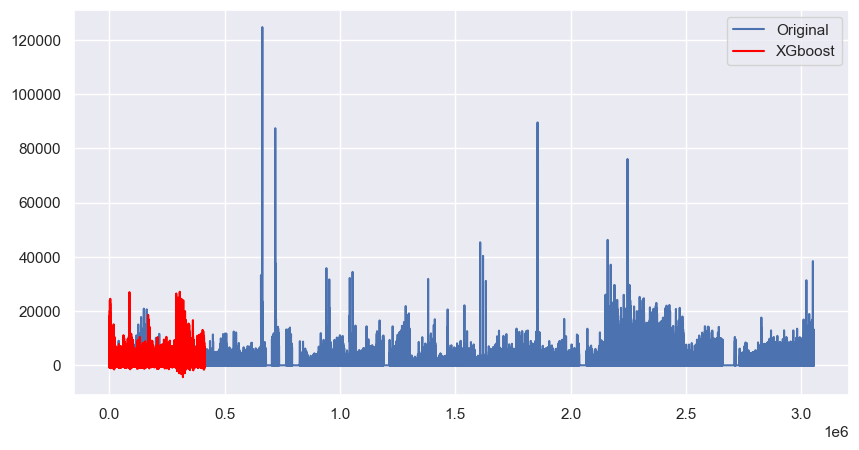

In [128]:
# Visual Representation

plt.plot(Transformed_merge.sales.values, label='Original')
plt.plot(boost_pred, color='red', label='XGboost')
plt.legend()

In [129]:
#neigh = KNeighborsRegressor(n_neighbors=2)
# fit model no training data
#neigh.fit(X_train, y_train)

# make predictions for test data
#neigh_pred = neigh.predict(X_eval)


In [130]:
#mse = mean_squared_error(y_eval, neigh_pred )
#rmse = np.sqrt(mean_squared_error(y_eval, neigh_pred )).round(2)


#Outcome_4 = pd.DataFrame([['KNN', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
#Outcome_4                  

__Back testing testing to see how the model performs__


__XGBOOST__

In [131]:
backtests = {
    1: ('2018-02-01', '2018-02-16'),
    2: ('2019-09-15', '2019-09-29'),
    3: ('2020-08-01', '2020-08-15'),
}

In [132]:
# Backtests with XGBOOST
scores = {}

for idx, period in enumerate(backtests):

    _train = Transformed_merge.reset_index()[Transformed_merge.reset_index()['date'] < backtests[period][0]]
    _eval = Transformed_merge.reset_index()[(Transformed_merge.reset_index()['date'] >= backtests[period][0]) & (Transformed_merge.reset_index()['date'] <= backtests[period][1])]

    Xtrain, ytrain = _train.set_index(['date']).drop(columns=['sales']).values, _train.sales.values
    Xeval, yeval = _eval.set_index(['date']).drop(columns=['sales']).values, _eval.sales.values

    boost_model = XGBRegressor().fit(Xtrain, ytrain)

    ypred = boost_model.predict(Xeval)

    scores[period] = np.sqrt(mean_squared_log_error(yeval, ypred))

print(scores)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

### TIME SERIES MODELS 

__AR MODEL__

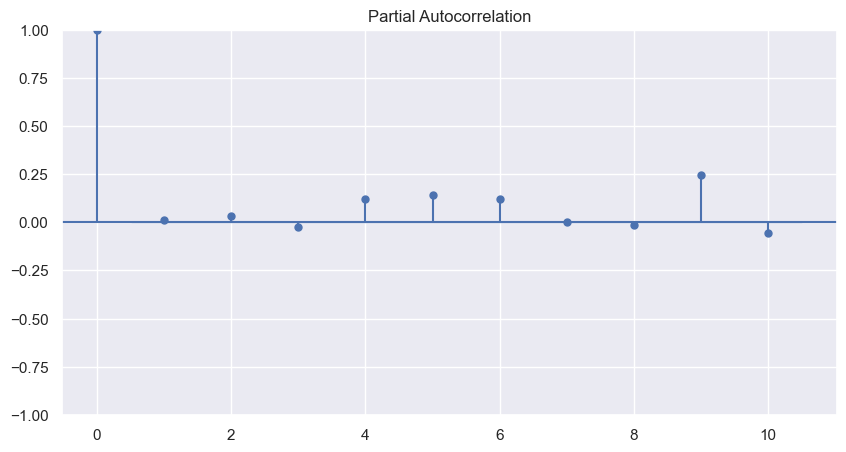

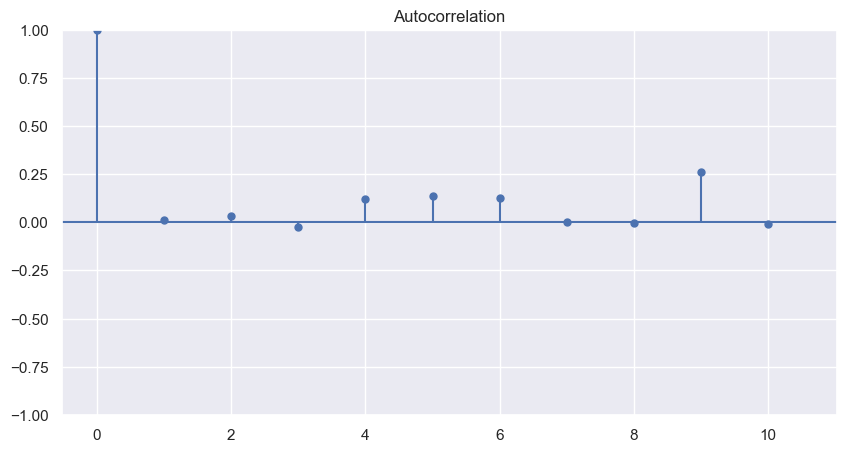

In [135]:
pacf = PACF(y_train, lags = 10)
acf = ACF(y_train, lags = 10)

In [136]:
#from statsmodels.tsa.ar.model import AutoReg

In [139]:
model = AutoReg(X_train, lags = 5).fit()
model.summary()

MemoryError: Unable to allocate 5.20 GiB for an array with shape (2642711, 264) and data type float64

In [ ]:
AR_pred = model.predict(start = len(X_train), end = len(X_train) + len(X_eval) - 1, dynamic = False)

<function matplotlib.pyplot.show(close=None, block=None)>

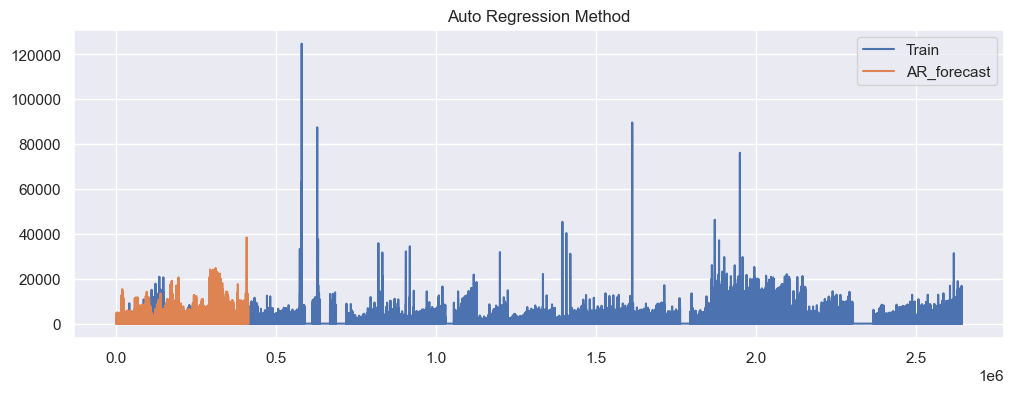

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_train, label = "Train")
plt.plot(y_eval, label = "Test" )
plt.plot(AR_pred, label = "ARIMA_forecast" )
plt.legend(loc="best")
plt.title('Auto Regression Method')
plt.show

In [ ]:
mse = mean_squared_error(y_eval, AR_pred)
msle = mean_squared_log_error(y_eval, AR_pred)
rmse = np.sqrt(mean_squared_error(y_eval, AR_pred)).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, AR_pred)).round(2)

result1 = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE','RMSE', 'RMSLE']) 
result1

Model           MSE       MSLE     RMSE  RMSLE
0    AR  2.076723e+06  19.308614  1441.08   4.39

__ARIMA__

In [ ]:
#stepwise_fit = auto_arima(y_train, trace =True, suppress_warnings = True)
#stepwise_fit.summary()

Performing stepwise search to minimize aic


MemoryError: Unable to allocate 323. MiB for an array with shape (4, 4, 2642707) and data type float64

: 

: 

In [ ]:
model_x= auto_arima(y_train, m= 12, seasonal= True, start_p= 0, start_q= 0, max_p= 10, max_q= 15, max_d= 5, d= 1, 
                   test= "adf", error_action= "ignore"
                   , suppress_warnings= True, stepwise= True, trace= True,  information_criterion='aic')

NameError: name 'auto_arima' is not defined

In [ ]:
model_1 = ARIMA(X_train, order=(5,1,6))
model_1_fit = model.fit()
model_1_fit.summary()

In [ ]:
ARIMA_pred = model_1_fit.predict(start = len(X_train), end = len(X_train) + len(X_eval) - 1, typ = 'levels')
print(ARIMA_pred)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_train, label = "Train")
plt.plot(y_eval, label = "Test" )
plt.plot(ARIMA_pred, label = "ARIMA_forecast" )
plt.legend(loc="best")
plt.title('Auto Regression Integrated Moving Average (ARIMA) Method')
plt.show

In [ ]:
mse = mean_squared_error(y_eval, ARIMA_pred)
msle = mean_squared_log_error(y_eval, ARIMA_pred)
rmse = np.sqrt(mean_squared_error(y_eval, ARIMA_pred)).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, ARIMA_pred)).round(2)

model_result = pd.DataFrame([['ARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE','RMSE', 'RMSLE']) 
result1 = result1.append(model_result, ignore_index = True)
result1

__SARIMA MODEL__

In [140]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [141]:
model_2 = SARIMAX(X_train, order = (1,1,1), seasonal_order= (1,1,1,12))
model_2fit = model_2.fit()
model_2fit

MemoryError: Unable to allocate 887. MiB for an array with shape (44, 2642706) and data type float64

In [ ]:
SARIMA_pred = model_2fit.predict(start = len(X_train), end = len(X_train) + len(X_eval) - 1, typ = 'levels')
print(SARIMA_pred)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_train, label = "Train")
plt.plot(y_eval, label = "Test" )
plt.plot(SARIMA_pred, label = "SARIMA_forecast" )
plt.legend(loc="best")
plt.title('Seasonal Auto Regression Integrated Moving Average (ARIMA) Method')
plt.show

In [ ]:
mse = mean_squared_error(y_eval, SARIMA_pred)
msle = mean_squared_log_error(y_eval, SARIMA_pred)
rmse = np.sqrt(mean_squared_error(y_eval, SARIMA_pred)).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, SARIMA_pred)).round(2)

model2_result = pd.DataFrame([['SARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE','RMSE', 'RMSLE']) 
result1 = result1.append(model2_result, ignore_index = True)
result1